cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.61e+00 | test_loss: 1.71e+00 | reg: 2.76e+01 | : 100%|█| 200/200 [00:31<00:00,  6.39


saving model version 0.1
MAE: 1.2358
MSE: 2.9095
MAPE: 3.3631
R²: 0.9930
RMSE: 1.7057
fixing (0,0,0) with log10, r2=0.9973500370979309, c=1
fixing (0,0,1) with log10, r2=0.9918974041938782, c=1
fixing (0,0,2) with x, r2=0.9848658442497253, c=1
fixing (0,1,0) with log10, r2=0.9987611770629883, c=1
fixing (0,1,1) with 0, r2=0.0, c=0
fixing (0,1,2) with log10, r2=0.9913429617881775, c=1
fixing (0,2,0) with log10, r2=0.9689542055130005, c=1
fixing (0,2,1) with 0, r2=0.0, c=0
fixing (0,2,2) with 0, r2=0.0, c=0
fixing (0,3,0) with log10, r2=0.9878170490264893, c=1
fixing (0,3,1) with 0, r2=0.0, c=0
fixing (0,3,2) with x, r2=0.9999946355819702, c=1
fixing (0,4,0) with x, r2=0.9987390637397766, c=1
fixing (0,4,1) with x, r2=0.9995759129524231, c=1
fixing (0,4,2) with x, r2=0.9999687075614929, c=1
fixing (0,5,0) with x, r2=0.9999666810035706, c=1
fixing (0,5,1) with 0, r2=0.0, c=0
fixing (0,5,2) with x, r2=0.9999349117279053, c=1
fixing (1,0,0) with x, r2=0.9999992251396179, c=1
fixing (1,0,1) 

0.069*x_1 - 0.372*x_4 + 0.146*x_5 + 1.026*x_6 - 153.037*log10(7.933 - 1.387*x_1) - 180.08*log10(9.82 - 1.619*x_2) - 148.908*log10(9.989 - 0.168*x_3) + 0.182*log10(3.989*x_2 + 2.98) + 107.276*log10(0.2*x_4 + 10.0) + 135.6*log10(-0.008*x_5 + 8.354*log10(0.175*x_1 + 0.884) + 6.173) + 236.803

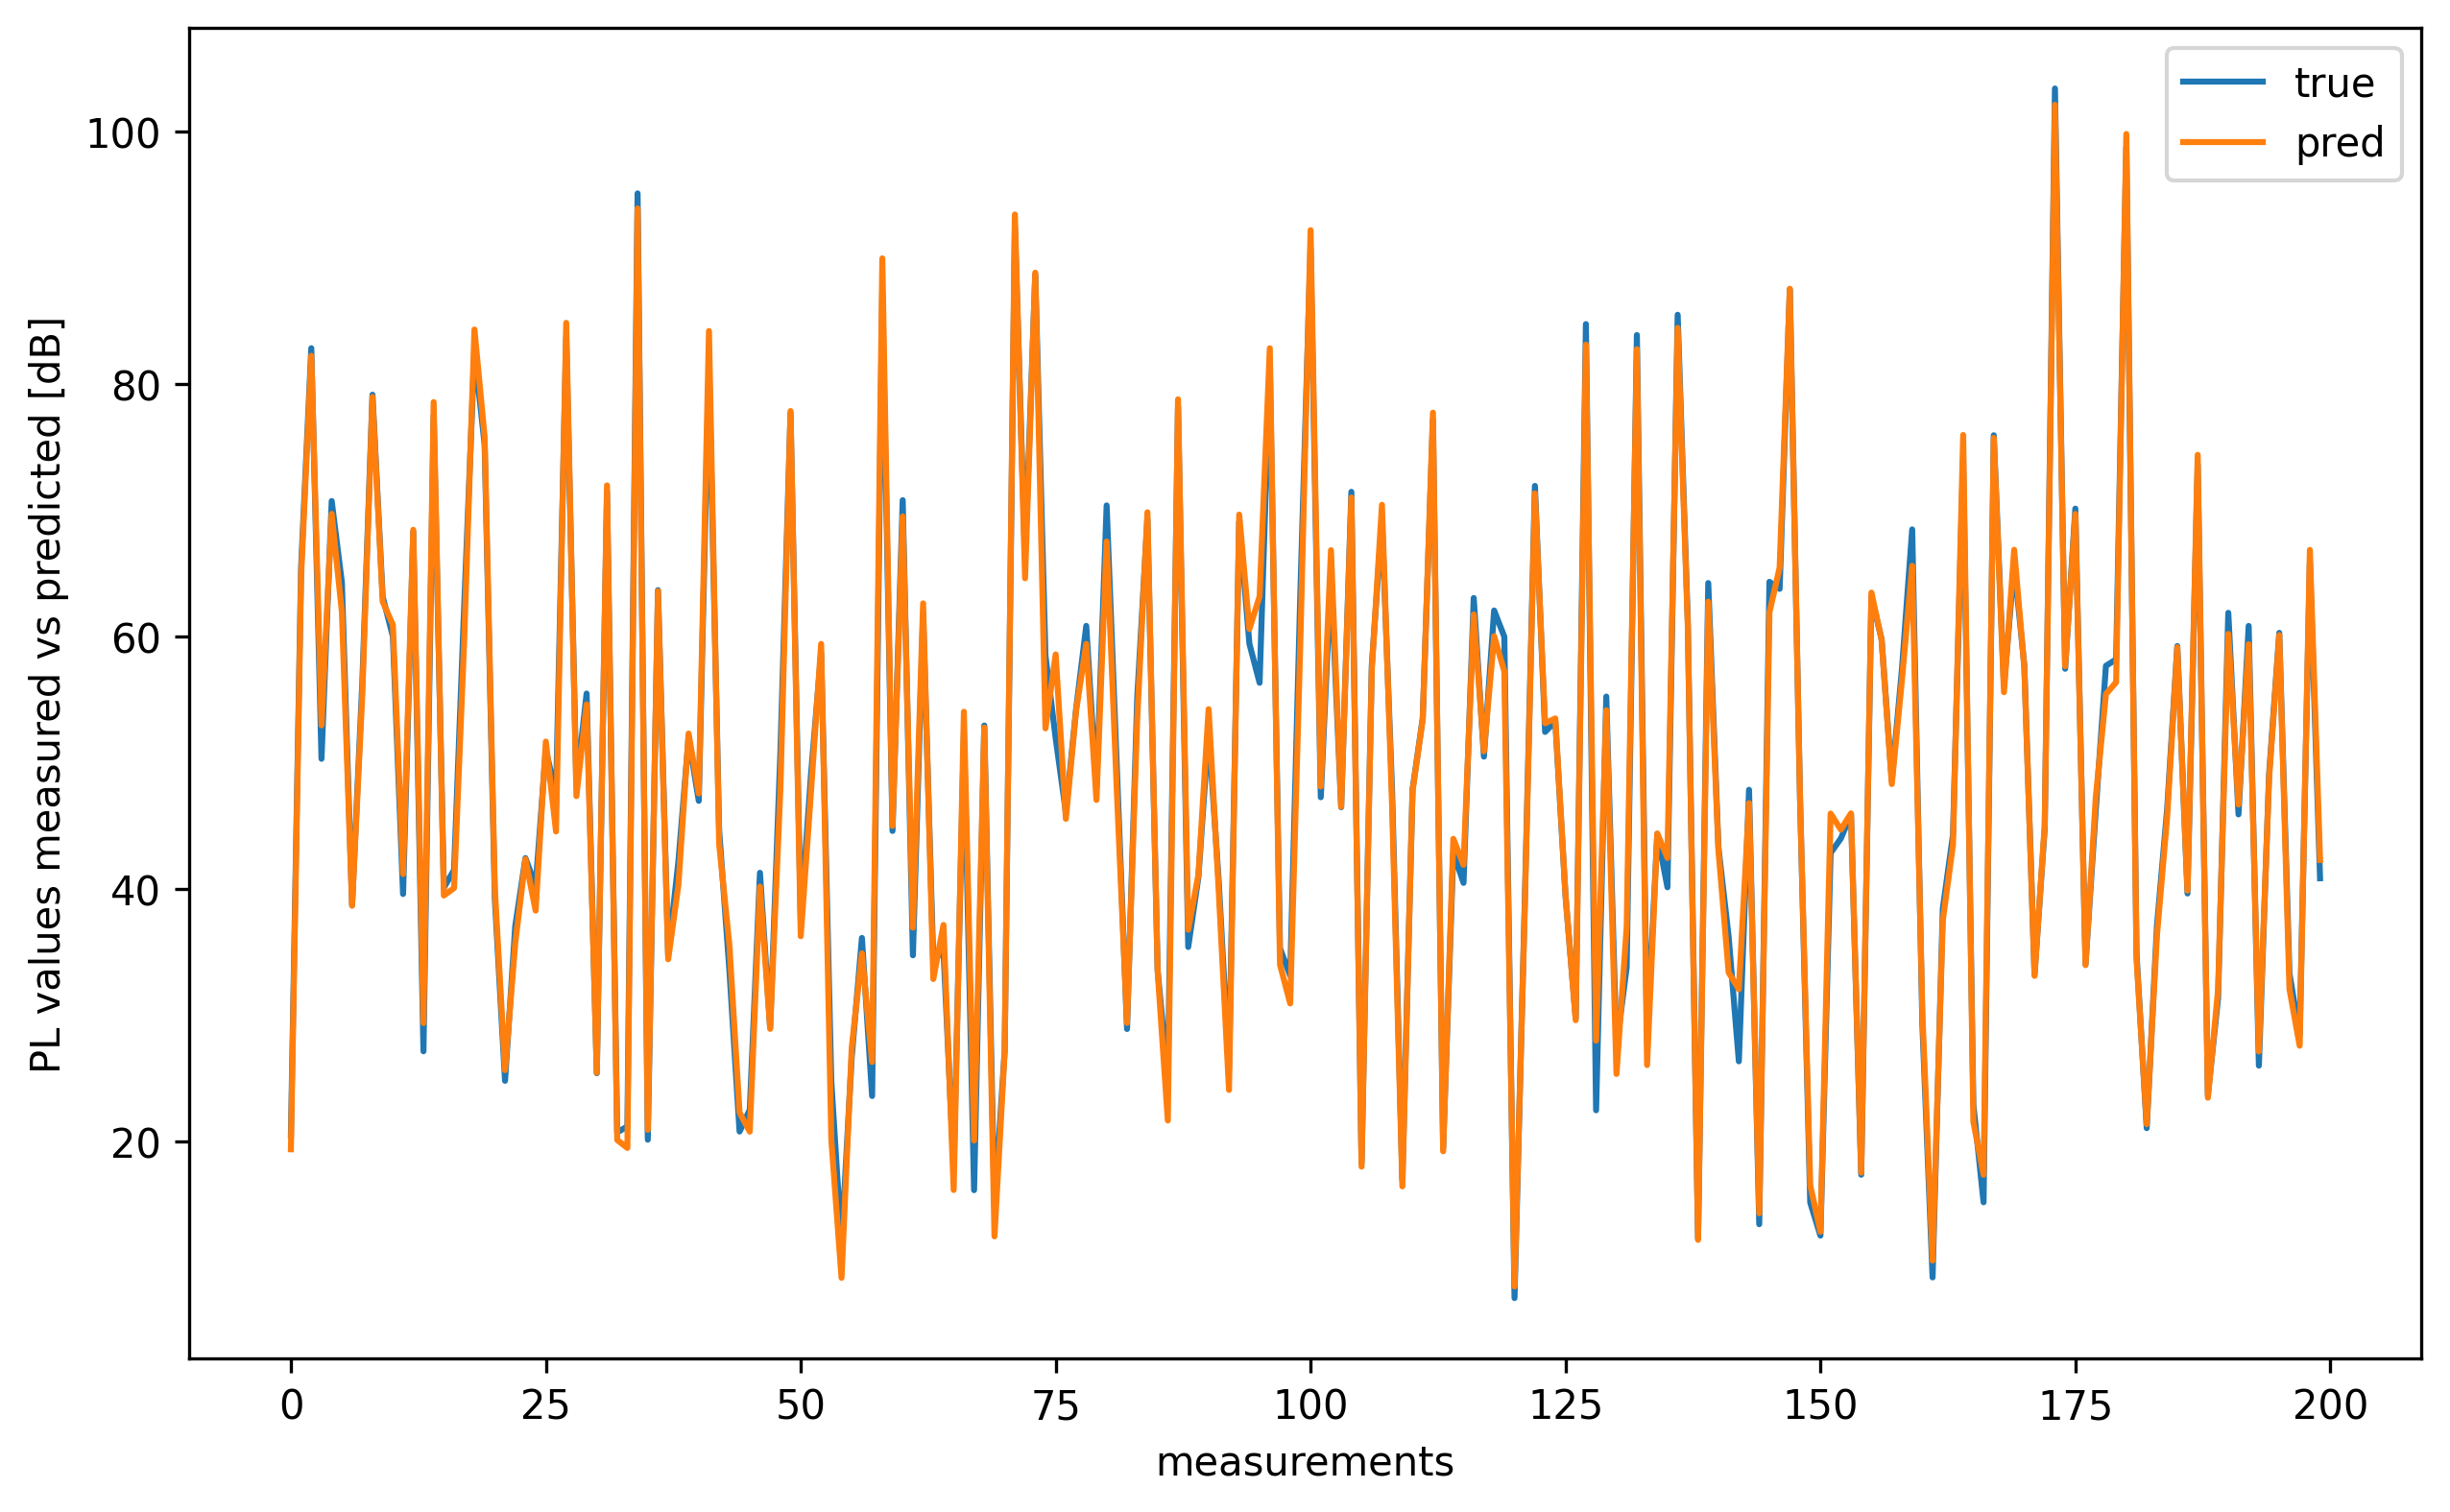

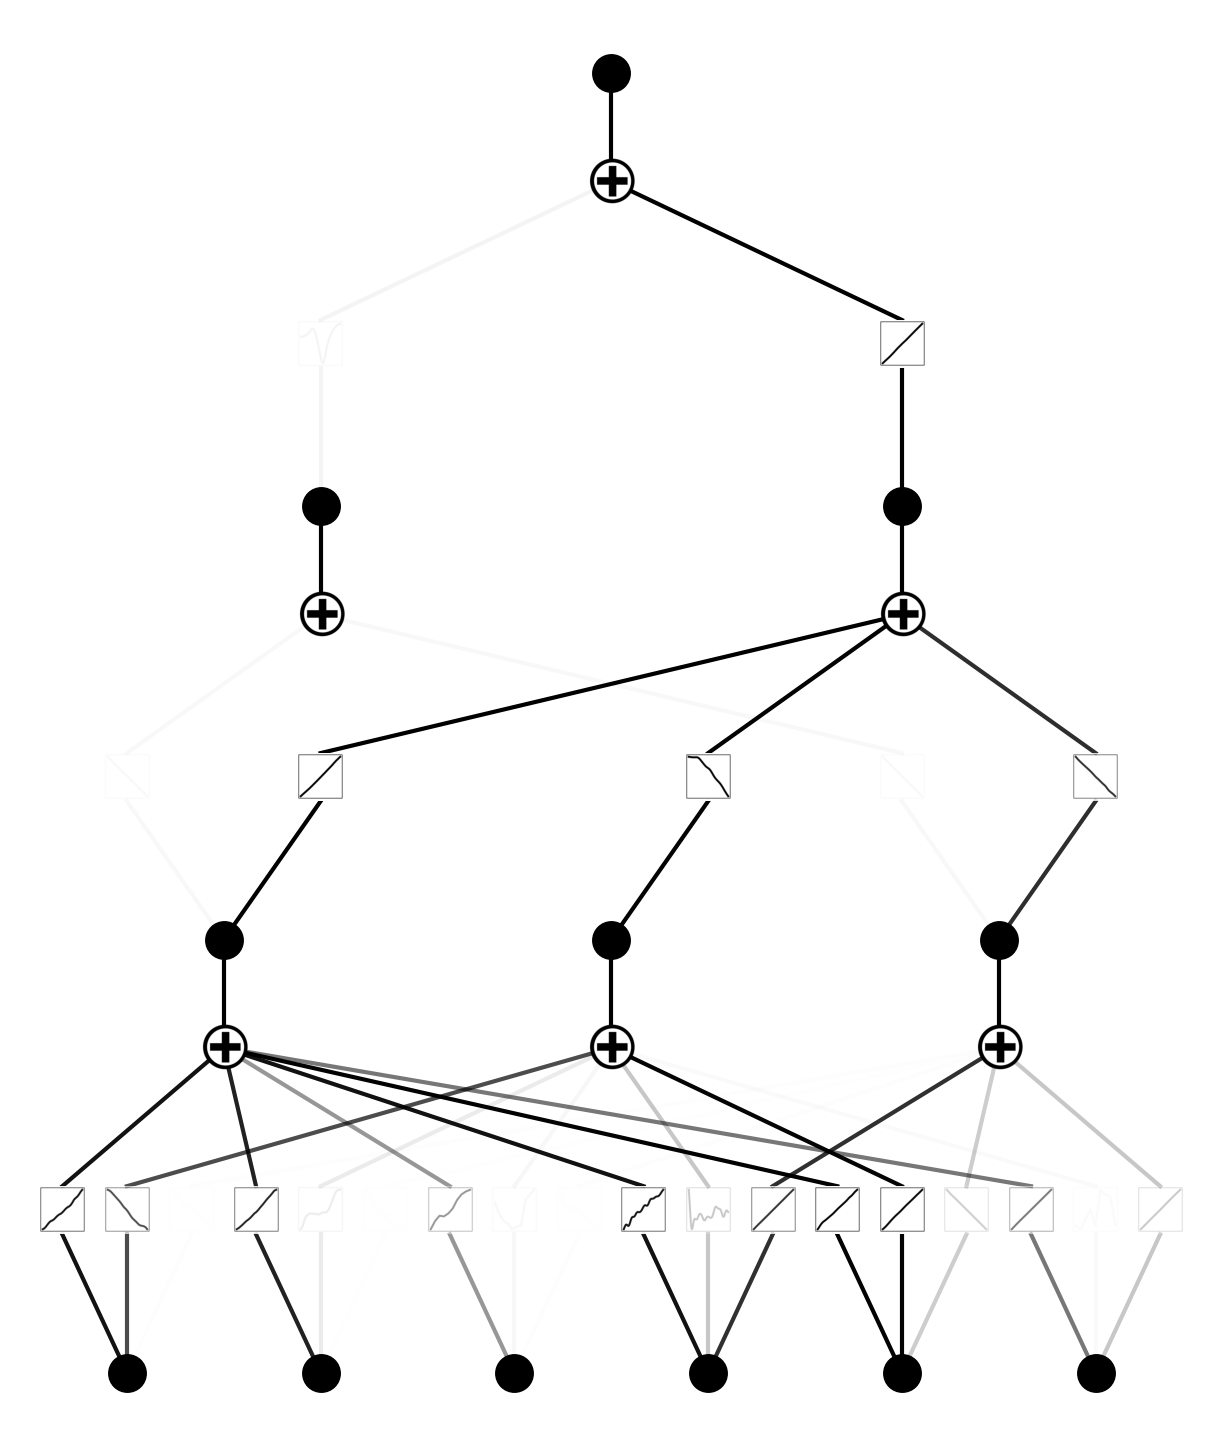

In [22]:

from kan import *
import torch

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


def eval_kan(model_kan, f, test_data):
    y_true = test_data['test_label']
    with torch.no_grad():
        y_pred = model_kan(test_data['test_input'])
        
    y_true = y_true.detach().cpu().numpy().ravel()[:250]
    y_pred = y_pred.detach().cpu().numpy().ravel()[:250]
    time = range(len(y_true))

    # Plot the training and test losses.
    plt.plot(time, y_true)
    plt.plot(time, y_pred)
    if f is not nan:
        y_symbolic = f(test_data['test_input'])[:250]
        plt.plot(time, y_symbolic)
        plt.legend(['true', 'pred', 'symbolic'])
    else:
        plt.legend(['true', 'pred'])
    plt.ylabel('PL values measured vs predicted [dB]')
    plt.xlabel('measurements')


    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    mape_frac = mean_absolute_percentage_error(y_true, y_pred)
    mape = mape_frac * 100
    
    # Print results
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

    return mse, rmse, mae, mape, r2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_gids_steps_lambda_loss(gids_size, steps, lam, metric, metric_name):
    """
    Plots a 3D scatter of gids_size vs steps vs train_loss, 
    with point color representing lambda.
    
    Parameters:
    - gids_size: array-like of shape (N,)
    - steps: array-like of shape (N,)
    - lam: array-like of shape (N,)
    - train_loss: array-like of shape (N,)
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(gids_size, steps, lam, c=metric)
    
    ax.set_xlabel('gids size')
    ax.set_ylabel('steps')
    ax.set_zlabel('lambda')
    
    plt.colorbar(sc, label=metric_name)
    plt.title('3D Scatter: gids size vs steps vs lambda (' + metric_name + ' as color)')
    plt.show()


# Read the data from the Excel file
abg_data = pd.read_excel('Propagation_models.xlsx', sheet_name='ABG', header=0)

# First row contains normalization factors, let's store it
first_row = abg_data.iloc[0]

# Drop the first row after using it for normalization
abg_data = abg_data.drop(index=0)

# Clean column names by stripping whitespace
abg_data.columns = abg_data.columns.str.strip()

# Convert specified columns to floats
for col in ['alpha', 'gamma', 'beta', 'f', 'd', 'X']:
    abg_data[col] = pd.to_numeric(abg_data[col], errors='coerce').astype(float)

# Check for any NaN values after conversion
if abg_data.isnull().any().any():
    print("Warning: NaN values detected in the dataset.")

# Assuming `inputs` and `labels` are your raw data as numpy arrays
inputs = abg_data[['alpha', 'gamma', 'beta', 'f', 'd', 'X']].values  
labels = abg_data['PL_ABG'].values    # Output labels (PL_ABG)

# Split into 80% train + 20% test
train_input, test_input, train_label, test_label = train_test_split(
    inputs, labels, test_size=0.2, random_state=42
)
train_input = torch.tensor(train_input, dtype=torch.float32)
test_input = torch.tensor(test_input, dtype=torch.float32)
train_label = torch.tensor(train_label, dtype=torch.float32).unsqueeze(1)
test_label = torch.tensor(test_label, dtype=torch.float32).unsqueeze(1)

# Prepare the dataset dictionary
dataset = {
    'train_input': train_input,
    'test_input': test_input,
    'train_label': train_label,
    'test_label': test_label
}

# Develop the KAN model using an approach where we assume more complex formulas  
# therefore we defined a deeper architecture as in the example KAP tutoprial
model = KAN(width=[6,3,2,1], grid=15, k=3, seed=42, device=device)

# this is the learnt KAN model (splines + edge weights)
model.fit(dataset, opt="LBFGS", steps=200, lamb=0.0002, lamb_entropy=2.);

eval_kan(model, nan, dataset)
model.plot()

# this is the symbolic approximation of the learnt splines with interpretable mathematical functions
add_symbolic('log10', torch.log10)
model.auto_symbolic()

ex_round(model.symbolic_formula()[0][0], 3)

MAE: 2.2914
MSE: 11.4671
MAPE: 6.8629
R²: 0.9726
RMSE: 3.3863


/var/folders/kp/ywhxwl8j55z_9fb901tc6x_w0000gp/T/ipykernel_4924/89309566.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = lambda x: 0.069 * x[:, 0] - 0.372 * x[:, 3] + 0.146 * x[:, 4] + 1.026 * x[:, 5] - 153.037 * np.log10(7.933 - 1.387 * x[:, 0]) - 180.08 * np.log10(9.82 - 1.619 * x[:, 1]) - 148.908 * np.log10(9.989 - 0.168 * x[:, 2]) + 0.182 * np.log10(3.989 * x[:, 1] + 2.98) + 107.276 * np.log10(0.2 * x[:, 3] + 10.0) + 135.6 * np.log10(-0.008 * x[:, 4] + 8.354 * np.log10(0.175 * x[:, 0] + 0.884) + 6.173) + 236.803


(11.467116355895996,
 np.float64(3.386313091829519),
 2.291398286819458,
 6.862936913967133,
 0.9726033210754395)

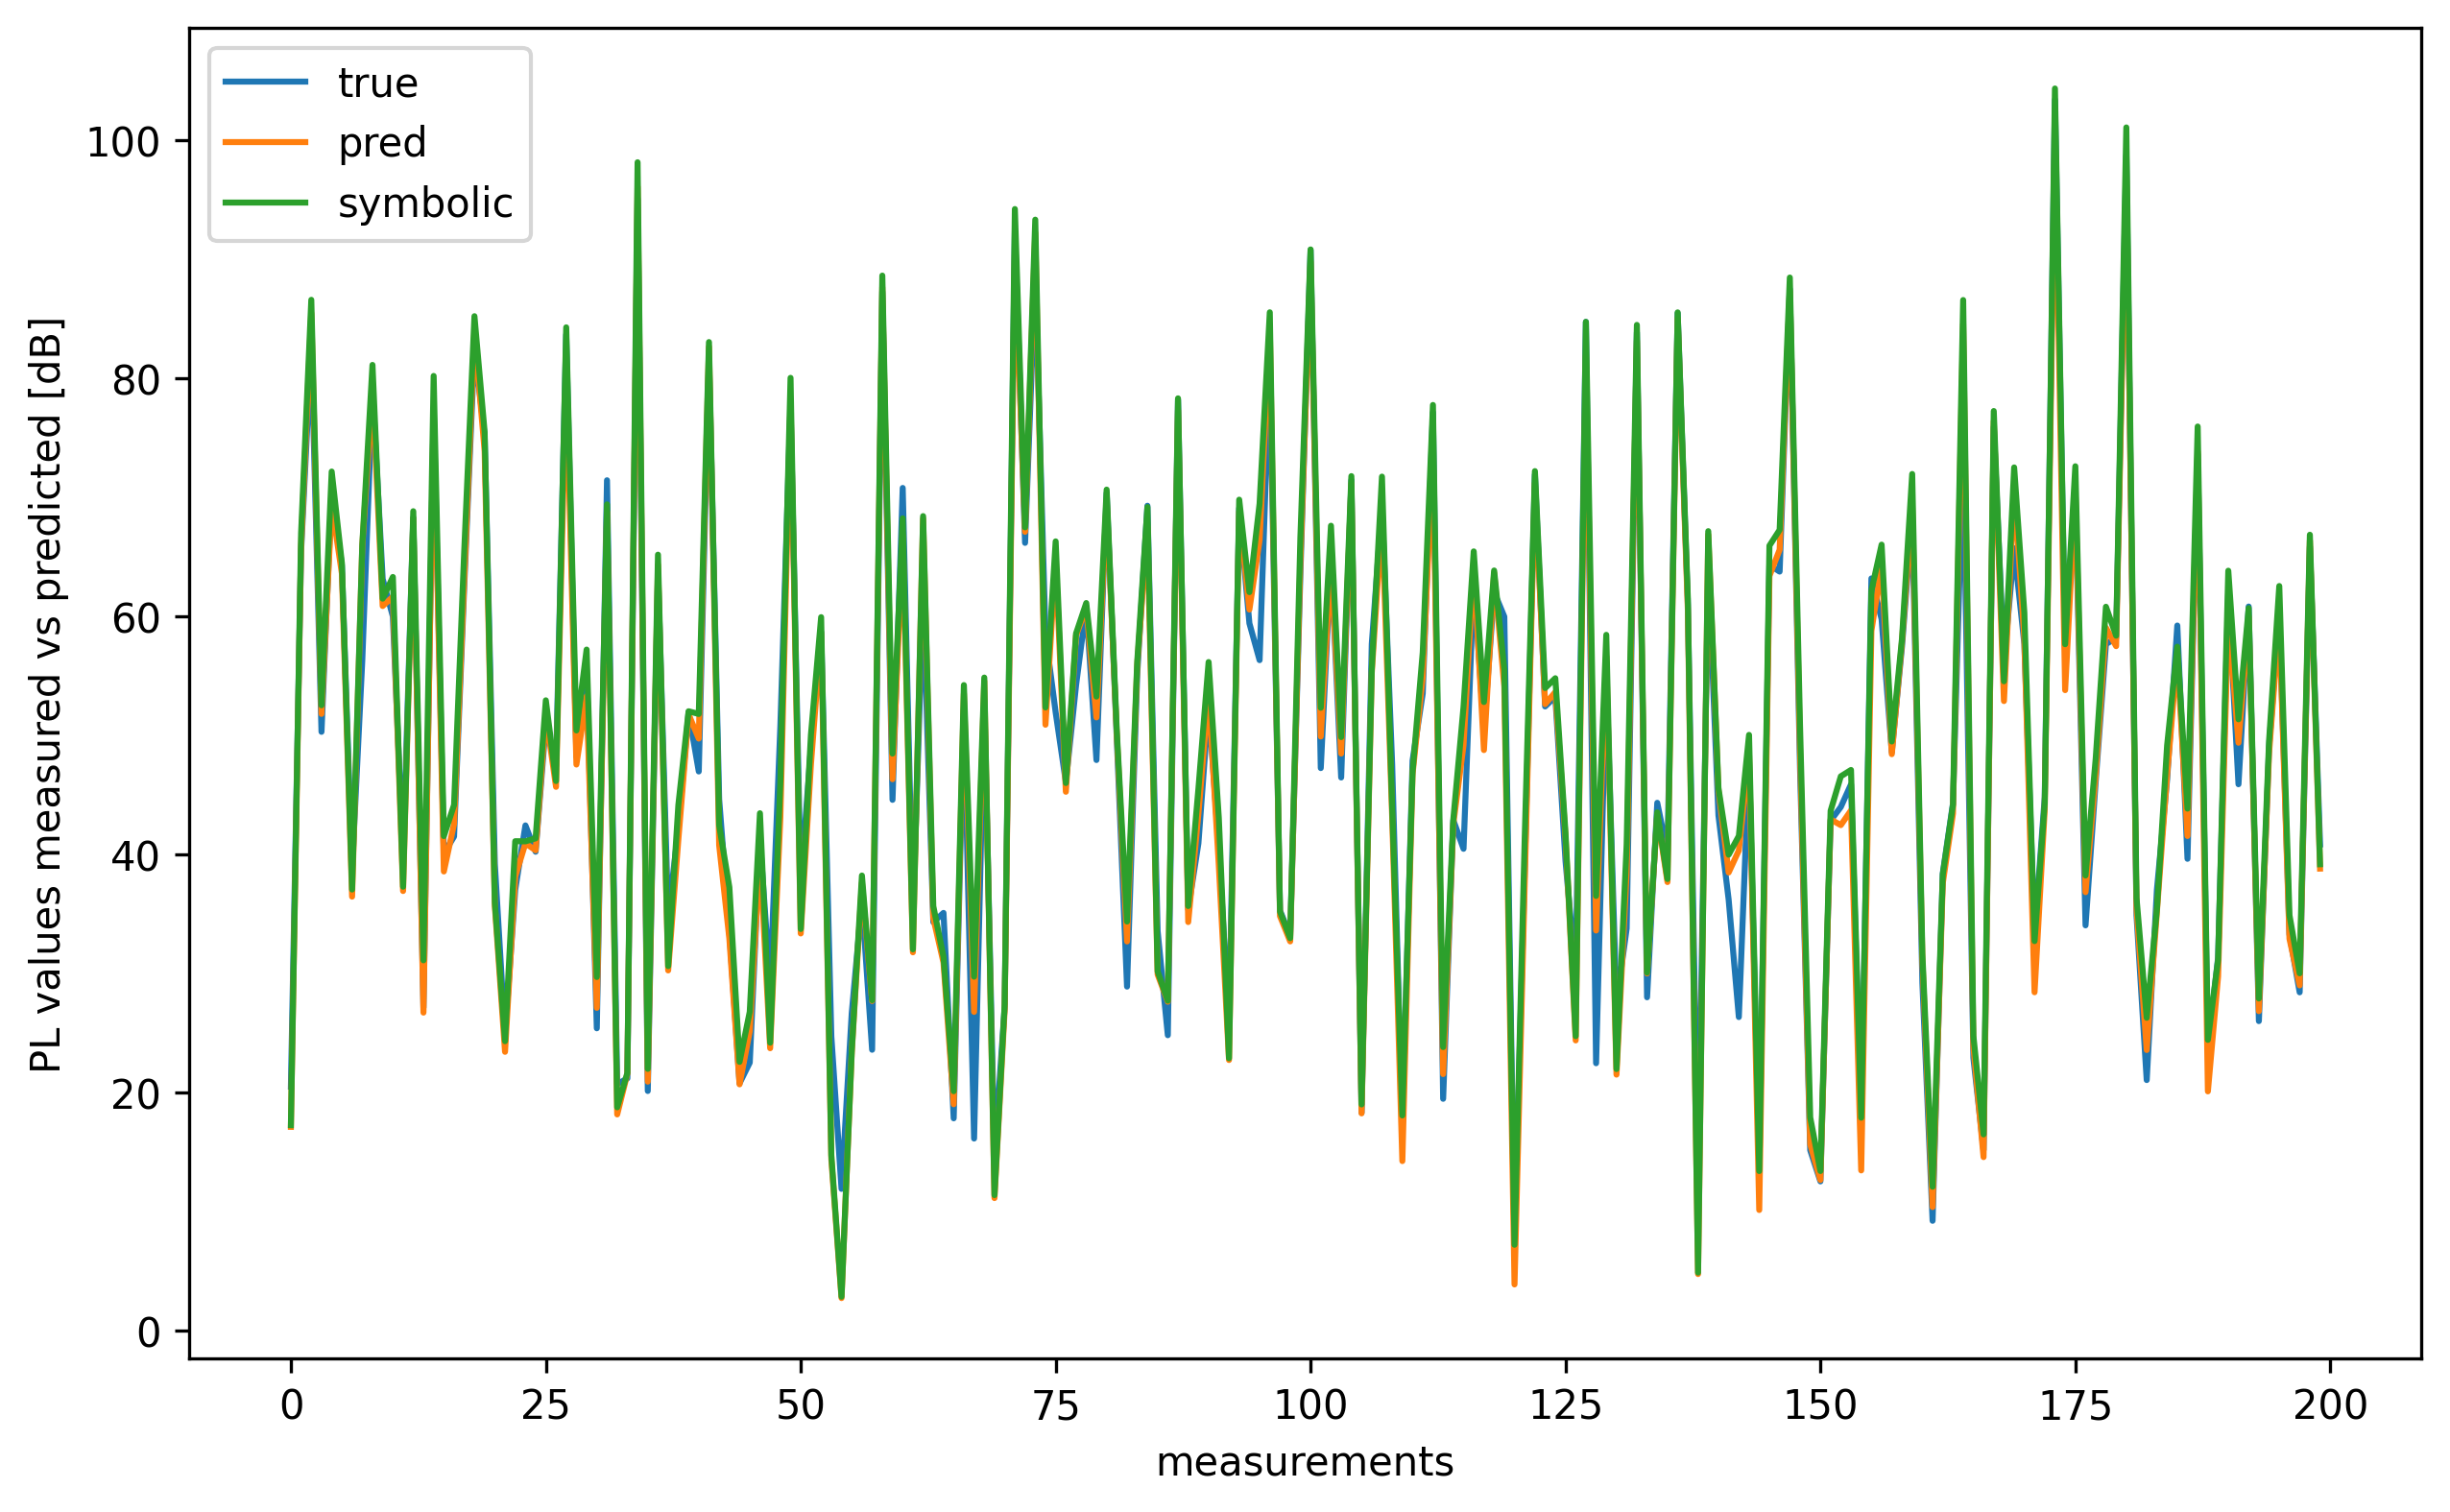

In [23]:

f = lambda x: 0.069 * x[:, 0] - 0.372 * x[:, 3] + 0.146 * x[:, 4] + 1.026 * x[:, 5] - 153.037 * np.log10(7.933 - 1.387 * x[:, 0]) - 180.08 * np.log10(9.82 - 1.619 * x[:, 1]) - 148.908 * np.log10(9.989 - 0.168 * x[:, 2]) + 0.182 * np.log10(3.989 * x[:, 1] + 2.98) + 107.276 * np.log10(0.2 * x[:, 3] + 10.0) + 135.6 * np.log10(-0.008 * x[:, 4] + 8.354 * np.log10(0.175 * x[:, 0] + 0.884) + 6.173) + 236.803
eval_kan(model, f, dataset)


checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 0.02


| train_loss: 1.92e+01 | test_loss: 1.93e+01 | reg: 3.12e+01 | : 100%|█| 50/50 [00:08<00:00,  5.82it


saving model version 0.1
MAE: 15.5069
MSE: 371.1577
MAPE: 45.7076
R²: 0.1132
RMSE: 19.2655
[np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 0.002


| train_loss: 3.28e+00 | test_loss: 4.24e+00 | reg: 7.05e+01 | : 100%|█| 50/50 [00:10<00:00,  4.79it


saving model version 0.1
MAE: 2.9218
MSE: 17.9657
MAPE: 8.3173
R²: 0.9571
RMSE: 4.2386
[np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 0.0002


| train_loss: 5.85e+00 | test_loss: 5.63e+00 | reg: 3.44e+01 | : 100%|█| 50/50 [00:11<00:00,  4.48it


saving model version 0.1
MAE: 3.5676
MSE: 31.6620
MAPE: 11.5096
R²: 0.9244
RMSE: 5.6269
[np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 2e-05


| train_loss: 1.92e+01 | test_loss: 1.95e+01 | reg: 1.10e+02 | : 100%|█| 50/50 [00:05<00:00,  9.36it


saving model version 0.1
MAE: 15.8178
MSE: 382.1727
MAPE: 45.5969
R²: 0.0869
RMSE: 19.5492
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 2e-06


| train_loss: 2.82e+00 | test_loss: 3.33e+00 | reg: 2.54e+01 | : 100%|█| 50/50 [00:11<00:00,  4.35it


saving model version 0.1
MAE: 2.2940
MSE: 11.0722
MAPE: 6.4248
R²: 0.9735
RMSE: 3.3275
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.02


| train_loss: 1.91e+01 | test_loss: 1.93e+01 | reg: 3.11e+01 | : 100%|█| 100/100 [00:13<00:00,  7.24


saving model version 0.1
MAE: 15.5186
MSE: 371.9350
MAPE: 45.4450
R²: 0.1114
RMSE: 19.2856
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.002


| train_loss: 2.75e+00 | test_loss: 3.15e+00 | reg: 6.82e+01 | : 100%|█| 100/100 [00:22<00:00,  4.37


saving model version 0.1
MAE: 2.1265
MSE: 9.9475
MAPE: 5.8510
R²: 0.9762
RMSE: 3.1540
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.0002


| train_loss: 5.27e+00 | test_loss: 5.17e+00 | reg: 3.45e+01 | : 100%|█| 100/100 [00:21<00:00,  4.57


saving model version 0.1
MAE: 3.1822
MSE: 26.7553
MAPE: 9.1590
R²: 0.9361
RMSE: 5.1726
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 2e-05


| train_loss: 1.92e+01 | test_loss: 1.94e+01 | reg: 1.09e+02 | : 100%|█| 100/100 [00:10<00:00,  9.72


saving model version 0.1
MAE: 15.6928
MSE: 374.7262
MAPE: 45.6642
R²: 0.1047
RMSE: 19.3578
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 2e-06


| train_loss: 2.49e+00 | test_loss: 2.85e+00 | reg: 2.67e+01 | : 100%|█| 100/100 [00:21<00:00,  4.56


saving model version 0.1
MAE: 1.8965
MSE: 8.1237
MAPE: 5.0422
R²: 0.9806
RMSE: 2.8502
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.02


| train_loss: 1.90e+01 | test_loss: 1.92e+01 | reg: 3.13e+01 | : 100%|█| 200/200 [00:21<00:00,  9.24


saving model version 0.1
MAE: 15.4094
MSE: 367.5470
MAPE: 44.8551
R²: 0.1219
RMSE: 19.1715
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.002


| train_loss: 2.59e+00 | test_loss: 2.88e+00 | reg: 6.60e+01 | : 100%|█| 200/200 [00:42<00:00,  4.71


saving model version 0.1
MAE: 1.9821
MSE: 8.2872
MAPE: 5.2736
R²: 0.9802
RMSE: 2.8788
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.0002


| train_loss: 4.83e+00 | test_loss: 5.00e+00 | reg: 3.62e+01 | : 100%|█| 200/200 [00:37<00:00,  5.28


saving model version 0.1
MAE: 3.0243
MSE: 24.9855
MAPE: 8.8058
R²: 0.9403
RMSE: 4.9985
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 2e-05


| train_loss: 1.91e+01 | test_loss: 1.94e+01 | reg: 1.10e+02 | : 100%|█| 200/200 [00:21<00:00,  9.24


saving model version 0.1
MAE: 15.7221
MSE: 376.6877
MAPE: 46.0544
R²: 0.1000
RMSE: 19.4084
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 2e-06


| train_loss: 2.19e+00 | test_loss: 2.58e+00 | reg: 2.86e+01 | : 100%|█| 200/200 [00:45<00:00,  4.38


saving model version 0.1
MAE: 1.6122
MSE: 6.6419
MAPE: 4.5065
R²: 0.9841
RMSE: 2.5772
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.02


| train_loss: 1.90e+01 | test_loss: 1.91e+01 | reg: 3.13e+01 | : 100%|█| 300/300 [00:31<00:00,  9.48


saving model version 0.1
MAE: 15.3783
MSE: 366.5031
MAPE: 44.6033
R²: 0.1244
RMSE: 19.1443
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.002


| train_loss: 2.52e+00 | test_loss: 2.74e+00 | reg: 6.81e+01 | : 100%|█| 300/300 [00:53<00:00,  5.64


saving model version 0.1
MAE: 1.9347
MSE: 7.5207
MAPE: 5.2536
R²: 0.9820
RMSE: 2.7424
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.0002


| train_loss: 4.78e+00 | test_loss: 4.99e+00 | reg: 3.62e+01 | : 100%|█| 300/300 [00:44<00:00,  6.71


saving model version 0.1
MAE: 2.9673
MSE: 24.8994
MAPE: 8.7096
R²: 0.9405
RMSE: 4.9899
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 2e-05


| train_loss: 1.91e+01 | test_loss: 1.94e+01 | reg: 1.10e+02 | : 100%|█| 300/300 [00:24<00:00, 12.08


saving model version 0.1
MAE: 15.7119
MSE: 375.4040
MAPE: 45.9194
R²: 0.1031
RMSE: 19.3753
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 2e-06


| train_loss: 2.16e+00 | test_loss: 2.56e+00 | reg: 2.84e+01 | : 100%|█| 300/300 [00:50<00:00,  5.90


saving model version 0.1
MAE: 1.5826
MSE: 6.5525
MAPE: 4.4720
R²: 0.9843
RMSE: 2.5598
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 0.02


| train_loss: 1.39e+01 | test_loss: 1.43e+01 | reg: 1.47e+02 | : 100%|█| 50/50 [00:10<00:00,  4.70it


saving model version 0.1
MAE: 11.4871
MSE: 203.5147
MAPE: 32.8027
R²: 0.5138
RMSE: 14.2659
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 0.002


| train_loss: 1.13e+01 | test_loss: 1.24e+01 | reg: 1.86e+02 | : 100%|█| 50/50 [00:10<00:00,  4.92it


saving model version 0.1
MAE: 9.5485
MSE: 153.2019
MAPE: 27.7091
R²: 0.6340
RMSE: 12.3775
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 0.0002


| train_loss: 1.35e+01 | test_loss: 1.59e+01 | reg: 1.24e+02 | : 100%|█| 50/50 [00:09<00:00,  5.27it


saving model version 0.1
MAE: 12.3493
MSE: 254.1945
MAPE: 34.8354
R²: 0.3927
RMSE: 15.9435
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 2e-05


| train_loss: 1.35e+01 | test_loss: 1.45e+01 | reg: 1.32e+02 | : 100%|█| 50/50 [00:08<00:00,  5.75it


saving model version 0.1
MAE: 11.1154
MSE: 211.3804
MAPE: 33.6702
R²: 0.4950
RMSE: 14.5389
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 2e-06


| train_loss: 1.25e+01 | test_loss: 1.30e+01 | reg: 1.07e+02 | : 100%|█| 50/50 [00:08<00:00,  5.61it


saving model version 0.1
MAE: 10.0435
MSE: 168.6481
MAPE: 28.9301
R²: 0.5971
RMSE: 12.9865
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.02


| train_loss: 7.03e+00 | test_loss: 8.13e+00 | reg: 1.48e+02 | : 100%|█| 100/100 [00:17<00:00,  5.67


saving model version 0.1
MAE: 6.3994
MSE: 66.1117
MAPE: 18.8713
R²: 0.8420
RMSE: 8.1309
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.002


| train_loss: 9.17e+00 | test_loss: 1.10e+01 | reg: 1.96e+02 | : 100%|█| 100/100 [00:16<00:00,  5.96


saving model version 0.1
MAE: 8.5256
MSE: 120.9623
MAPE: 25.1788
R²: 0.7110
RMSE: 10.9983
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.0002


| train_loss: 1.14e+01 | test_loss: 1.45e+01 | reg: 1.45e+02 | : 100%|█| 100/100 [00:20<00:00,  4.99


saving model version 0.1
MAE: 10.8297
MSE: 209.7138
MAPE: 30.2638
R²: 0.4990
RMSE: 14.4815
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 2e-05


| train_loss: 8.57e+00 | test_loss: 9.64e+00 | reg: 1.49e+02 | : 100%|█| 100/100 [00:18<00:00,  5.47


saving model version 0.1
MAE: 7.4245
MSE: 92.9341
MAPE: 21.9794
R²: 0.7780
RMSE: 9.6402
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 2e-06


| train_loss: 9.99e+00 | test_loss: 1.09e+01 | reg: 1.07e+02 | : 100%|█| 100/100 [00:17<00:00,  5.58


saving model version 0.1
MAE: 8.0307
MSE: 119.0057
MAPE: 21.2764
R²: 0.7157
RMSE: 10.9090
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.02


| train_loss: 4.47e+00 | test_loss: 5.21e+00 | reg: 1.39e+02 | : 100%|█| 200/200 [00:36<00:00,  5.45


saving model version 0.1
MAE: 3.9776
MSE: 27.1719
MAPE: 11.2937
R²: 0.9351
RMSE: 5.2127
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.002


| train_loss: 7.31e+00 | test_loss: 9.81e+00 | reg: 2.08e+02 | : 100%|█| 200/200 [00:35<00:00,  5.69


saving model version 0.1
MAE: 6.9746
MSE: 96.1587
MAPE: 19.6054
R²: 0.7703
RMSE: 9.8061
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.0002


| train_loss: 9.84e+00 | test_loss: 1.20e+01 | reg: 1.54e+02 | : 100%|█| 200/200 [00:33<00:00,  5.95


saving model version 0.1
MAE: 9.5795
MSE: 143.5968
MAPE: 26.3710
R²: 0.6569
RMSE: 11.9832
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 2e-05


| train_loss: 6.00e+00 | test_loss: 7.33e+00 | reg: 1.58e+02 | : 100%|█| 200/200 [00:34<00:00,  5.84


saving model version 0.1
MAE: 5.1413
MSE: 53.6958
MAPE: 13.7019
R²: 0.8717
RMSE: 7.3277
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 2e-06


| train_loss: 7.80e+00 | test_loss: 9.73e+00 | reg: 1.10e+02 | : 100%|█| 200/200 [00:36<00:00,  5.41


saving model version 0.1
MAE: 6.8031
MSE: 94.6903
MAPE: 19.2534
R²: 0.7738
RMSE: 9.7309
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.02


| train_loss: 3.82e+00 | test_loss: 4.47e+00 | reg: 1.34e+02 | : 100%|█| 300/300 [01:03<00:00,  4.75


saving model version 0.1
MAE: 3.2510
MSE: 20.0170
MAPE: 9.2667
R²: 0.9522
RMSE: 4.4740
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.002


| train_loss: 6.13e+00 | test_loss: 8.13e+00 | reg: 2.26e+02 | : 100%|█| 300/300 [00:58<00:00,  5.13


saving model version 0.1
MAE: 5.9089
MSE: 66.1513
MAPE: 16.3921
R²: 0.8420
RMSE: 8.1333
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.0002


| train_loss: 9.07e+00 | test_loss: 1.09e+01 | reg: 1.56e+02 | : 100%|█| 300/300 [00:49<00:00,  6.01


saving model version 0.1
MAE: 8.6280
MSE: 117.8475
MAPE: 24.8180
R²: 0.7184
RMSE: 10.8558
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 2e-05


| train_loss: 4.89e+00 | test_loss: 5.60e+00 | reg: 1.59e+02 | : 100%|█| 300/300 [00:54<00:00,  5.53


saving model version 0.1
MAE: 4.3508
MSE: 31.3635
MAPE: 11.3998
R²: 0.9251
RMSE: 5.6003
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 2e-06


| train_loss: 6.25e+00 | test_loss: 7.18e+00 | reg: 1.15e+02 | : 100%|█| 300/300 [00:52<00:00,  5.70


saving model version 0.1
MAE: 5.2783
MSE: 51.5597
MAPE: 15.5264
R²: 0.8768
RMSE: 7.1805
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 50, 0.02


| train_loss: 3.49e+00 | test_loss: 4.02e+00 | reg: 8.24e+01 | : 100%|█| 50/50 [00:08<00:00,  5.66it


saving model version 0.1
MAE: 2.8120
MSE: 16.1604
MAPE: 8.3753
R²: 0.9614
RMSE: 4.0200
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 50, 0.002


| train_loss: 3.34e+00 | test_loss: 3.82e+00 | reg: 5.05e+01 | : 100%|█| 50/50 [00:08<00:00,  6.25it


saving model version 0.1
MAE: 2.6351
MSE: 14.5653
MAPE: 7.7889
R²: 0.9652
RMSE: 3.8165
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 50, 0.0002


| train_loss: 3.39e+00 | test_loss: 4.04e+00 | reg: 1.62e+02 | : 100%|█| 50/50 [00:10<00:00,  4.91it


saving model version 0.1
MAE: 2.8679
MSE: 16.2953
MAPE: 7.7443
R²: 0.9611
RMSE: 4.0367
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 50, 2e-05


| train_loss: 3.45e+00 | test_loss: 3.98e+00 | reg: 7.01e+01 | : 100%|█| 50/50 [00:07<00:00,  6.27it


saving model version 0.1
MAE: 2.7647
MSE: 15.8304
MAPE: 8.3956
R²: 0.9622
RMSE: 3.9787
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10

| train_loss: 5.07e+00 | test_loss: 5.34e+00 | reg: 4.71e+02 | : 100%|█| 50/50 [00:07<00:00,  6.27it


saving model version 0.1
MAE: 4.1531
MSE: 28.5555
MAPE: 12.0295
R²: 0.9318
RMSE: 5.3437
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model versi

| train_loss: 3.49e+00 | test_loss: 4.02e+00 | reg: 8.24e+01 | : 100%|█| 100/100 [00:11<00:00,  8.54


saving model version 0.1
MAE: 2.8120
MSE: 16.1604
MAPE: 8.3753
R²: 0.9614
RMSE: 4.0200
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
s

| train_loss: 3.33e+00 | test_loss: 3.83e+00 | reg: 5.07e+01 | : 100%|█| 100/100 [00:11<00:00,  8.57


saving model version 0.1
MAE: 2.6452
MSE: 14.6968
MAPE: 7.8259
R²: 0.9649
RMSE: 3.8336
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory

| train_loss: 2.64e+00 | test_loss: 3.25e+00 | reg: 1.57e+02 | : 100%|█| 100/100 [00:24<00:00,  4.09


saving model version 0.1
MAE: 2.3348
MSE: 10.5942
MAPE: 6.1960
R²: 0.9747
RMSE: 3.2549
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]


| train_loss: 3.45e+00 | test_loss: 3.98e+00 | reg: 7.01e+01 | : 100%|█| 100/100 [00:11<00:00,  8.37


saving model version 0.1
MAE: 2.7659
MSE: 15.8468
MAPE: 8.4032
R²: 0.9621
RMSE: 3.9808
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 5.07e+00 | test_loss: 5.34e+00 | reg: 4.71e+02 | : 100%|█| 100/100 [00:11<00:00,  8.49


saving model version 0.1
MAE: 4.1531
MSE: 28.5555
MAPE: 12.0295
R²: 0.9318
RMSE: 5.3437
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 3.49e+00 | test_loss: 4.02e+00 | reg: 8.24e+01 | : 100%|█| 200/200 [00:18<00:00, 11.06


saving model version 0.1
MAE: 2.8120
MSE: 16.1604
MAPE: 8.3753
R²: 0.9614
RMSE: 4.0200
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 3.32e+00 | test_loss: 3.81e+00 | reg: 5.10e+01 | : 100%|█| 200/200 [00:18<00:00, 10.53


saving model version 0.1
MAE: 2.6191
MSE: 14.5264
MAPE: 7.7839
R²: 0.9653
RMSE: 3.8114
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 2.40e+00 | test_loss: 2.90e+00 | reg: 1.49e+02 | : 100%|█| 200/200 [00:39<00:00,  5.08


saving model version 0.1
MAE: 1.9781
MSE: 8.3978
MAPE: 5.3435
R²: 0.9799
RMSE: 2.8979
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 3.45e+00 | test_loss: 3.98e+00 | reg: 7.01e+01 | : 100%|█| 200/200 [00:19<00:00, 10.21


saving model version 0.1
MAE: 2.7659
MSE: 15.8468
MAPE: 8.4032
R²: 0.9621
RMSE: 3.9808
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 5.07e+00 | test_loss: 5.34e+00 | reg: 4.71e+02 | : 100%|█| 200/200 [00:18<00:00, 10.61


saving model version 0.1
MAE: 4.1531
MSE: 28.5555
MAPE: 12.0295
R²: 0.9318
RMSE: 5.3437
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 3.49e+00 | test_loss: 4.02e+00 | reg: 8.24e+01 | : 100%|█| 300/300 [00:24<00:00, 12.18


saving model version 0.1
MAE: 2.8120
MSE: 16.1604
MAPE: 8.3753
R²: 0.9614
RMSE: 4.0200
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 3.32e+00 | test_loss: 3.81e+00 | reg: 5.10e+01 | : 100%|█| 300/300 [00:22<00:00, 13.44


saving model version 0.1
MAE: 2.6196
MSE: 14.5336
MAPE: 7.7868
R²: 0.9653
RMSE: 3.8123
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 2.40e+00 | test_loss: 2.90e+00 | reg: 1.49e+02 | : 100%|█| 300/300 [00:41<00:00,  7.24


saving model version 0.1
MAE: 1.9781
MSE: 8.3978
MAPE: 5.3435
R²: 0.9799
RMSE: 2.8979
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 3.45e+00 | test_loss: 3.98e+00 | reg: 7.01e+01 | : 100%|█| 300/300 [00:26<00:00, 11.51


saving model version 0.1
MAE: 2.7659
MSE: 15.8468
MAPE: 8.4032
R²: 0.9621
RMSE: 3.9808
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 5.07e+00 | test_loss: 5.34e+00 | reg: 4.71e+02 | : 100%|█| 300/300 [00:27<00:00, 10.96


saving model version 0.1
MAE: 4.1531
MSE: 28.5555
MAPE: 12.0295
R²: 0.9318
RMSE: 5.3437
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 2.55e+00 | test_loss: 3.17e+00 | reg: 4.79e+01 | : 100%|█| 50/50 [00:12<00:00,  4.03it


saving model version 0.1
MAE: 2.1282
MSE: 10.0749
MAPE: 5.8540
R²: 0.9759
RMSE: 3.1741
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 2.96e+00 | test_loss: 3.45e+00 | reg: 1.90e+02 | : 100%|█| 50/50 [00:13<00:00,  3.79it


saving model version 0.1
MAE: 2.4084
MSE: 11.9198
MAPE: 6.2749
R²: 0.9715
RMSE: 3.4525
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 2.31e+00 | test_loss: 2.78e+00 | reg: 2.81e+01 | : 100%|█| 50/50 [00:13<00:00,  3.74it


saving model version 0.1
MAE: 1.8242
MSE: 7.7231
MAPE: 4.9562
R²: 0.9815
RMSE: 2.7790
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.90e+00 | test_loss: 3.50e+00 | reg: 3.53e+01 | : 100%|█| 50/50 [00:12<00:00,  3.97it


saving model version 0.1
MAE: 2.4811
MSE: 12.2317
MAPE: 7.7855
R²: 0.9708
RMSE: 3.4974
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 3.23e+00 | test_loss: 3.84e+00 | reg: 6.50e+01 | : 100%|█| 50/50 [00:10<00:00,  4.64it


saving model version 0.1
MAE: 2.8294
MSE: 14.7418
MAPE: 8.8414
R²: 0.9648
RMSE: 3.8395
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 2.09e+00 | test_loss: 2.52e+00 | reg: 4.54e+01 | : 100%|█| 100/100 [00:21<00:00,  4.75


saving model version 0.1
MAE: 1.7627
MSE: 6.3665
MAPE: 4.7686
R²: 0.9848
RMSE: 2.5232
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.68e+00 | test_loss: 3.14e+00 | reg: 1.90e+02 | : 100%|█| 100/100 [00:20<00:00,  4.88


saving model version 0.1
MAE: 2.0894
MSE: 9.8322
MAPE: 5.7005
R²: 0.9765
RMSE: 3.1356
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.96e+00 | test_loss: 2.21e+00 | reg: 2.76e+01 | : 100%|█| 100/100 [00:24<00:00,  4.01


saving model version 0.1
MAE: 1.4606
MSE: 4.8769
MAPE: 4.2140
R²: 0.9883
RMSE: 2.2084
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.24e+00 | test_loss: 2.68e+00 | reg: 3.57e+01 | : 100%|█| 100/100 [00:24<00:00,  4.02


saving model version 0.1
MAE: 1.9166
MSE: 7.1802
MAPE: 5.4742
R²: 0.9828
RMSE: 2.6796
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.67e+00 | test_loss: 3.26e+00 | reg: 6.74e+01 | : 100%|█| 100/100 [00:24<00:00,  4.07


saving model version 0.1
MAE: 2.3322
MSE: 10.6020
MAPE: 7.3542
R²: 0.9747
RMSE: 3.2561
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 1.83e+00 | test_loss: 2.15e+00 | reg: 4.28e+01 | : 100%|█| 200/200 [00:51<00:00,  3.92


saving model version 0.1
MAE: 1.5872
MSE: 4.6143
MAPE: 4.3086
R²: 0.9890
RMSE: 2.1481
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.68e+00 | test_loss: 3.14e+00 | reg: 1.90e+02 | : 100%|█| 200/200 [00:29<00:00,  6.84


saving model version 0.1
MAE: 2.0894
MSE: 9.8322
MAPE: 5.7005
R²: 0.9765
RMSE: 3.1356
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.61e+00 | test_loss: 1.71e+00 | reg: 2.76e+01 | : 100%|█| 200/200 [00:57<00:00,  3.51


saving model version 0.1
MAE: 1.2358
MSE: 2.9095
MAPE: 3.3631
R²: 0.9930
RMSE: 1.7057
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.01e+00 | test_loss: 2.35e+00 | reg: 3.34e+01 | : 100%|█| 200/200 [00:53<00:00,  3.72


saving model version 0.1
MAE: 1.6386
MSE: 5.5135
MAPE: 4.3571
R²: 0.9868
RMSE: 2.3481
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.64e+00 | test_loss: 3.20e+00 | reg: 6.74e+01 | : 100%|█| 200/200 [00:44<00:00,  4.48


saving model version 0.1
MAE: 2.2915
MSE: 10.2554
MAPE: 7.1751
R²: 0.9755
RMSE: 3.2024
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 1.51e+00 | test_loss: 1.75e+00 | reg: 5.00e+01 | : 100%|█| 300/300 [01:12<00:00,  4.11


saving model version 0.1
MAE: 1.3153
MSE: 3.0641
MAPE: 3.5328
R²: 0.9927
RMSE: 1.7505
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.68e+00 | test_loss: 3.14e+00 | reg: 1.90e+02 | : 100%|█| 300/300 [00:49<00:00,  6.07


saving model version 0.1
MAE: 2.0894
MSE: 9.8322
MAPE: 5.7005
R²: 0.9765
RMSE: 3.1356
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.42e+00 | test_loss: 1.55e+00 | reg: 2.88e+01 | : 100%|█| 300/300 [01:16<00:00,  3.90


saving model version 0.1
MAE: 1.1517
MSE: 2.4147
MAPE: 3.1185
R²: 0.9942
RMSE: 1.5539
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.92e+00 | test_loss: 2.17e+00 | reg: 3.34e+01 | : 100%|█| 300/300 [01:00<00:00,  4.98


saving model version 0.1
MAE: 1.5497
MSE: 4.7014
MAPE: 4.0851
R²: 0.9888
RMSE: 2.1683
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.61e+00 | test_loss: 3.14e+00 | reg: 6.71e+01 | : 100%|█| 300/300 [00:53<00:00,  5.61


saving model version 0.1
MAE: 2.2588
MSE: 9.8637
MAPE: 6.9787
R²: 0.9764
RMSE: 3.1407
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.24e+00 | test_loss: 2.55e+00 | reg: 5.59e+01 | : 100%|█| 50/50 [00:13<00:00,  3.82it


saving model version 0.1
MAE: 1.8006
MSE: 6.4845
MAPE: 4.7408
R²: 0.9845
RMSE: 2.5465
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 5.97e+00 | test_loss: 1.02e+01 | reg: 4.55e+01 | : 100%|█| 50/50 [00:17<00:00,  2.87it


saving model version 0.1
MAE: 6.0110
MSE: 104.2144
MAPE: 19.3152
R²: 0.7510
RMSE: 10.2085
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002

| train_loss: 1.34e+01 | test_loss: 1.53e+01 | reg: 4.04e+01 | : 100%|█| 50/50 [00:20<00:00,  2.45it


saving model version 0.1
MAE: 11.7408
MSE: 233.4365
MAPE: 32.7317
R²: 0.4423
RMSE: 15.2786
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.000

| train_loss: 3.35e+00 | test_loss: 4.79e+00 | reg: 3.73e+01 | : 100%|█| 50/50 [00:17<00:00,  2.85it


saving model version 0.1
MAE: 2.8241
MSE: 22.9600
MAPE: 8.0019
R²: 0.9451
RMSE: 4.7917
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 1.03e+01 | test_loss: 1.12e+01 | reg: 3.99e+01 | : 100%|█| 50/50 [00:15<00:00,  3.18it


saving model version 0.1
MAE: 8.5089
MSE: 125.2361
MAPE: 23.2431
R²: 0.7008
RMSE: 11.1909
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002

| train_loss: 1.83e+00 | test_loss: 2.33e+00 | reg: 5.45e+01 | : 100%|█| 100/100 [00:32<00:00,  3.10


saving model version 0.1
MAE: 1.6027
MSE: 5.4388
MAPE: 4.3240
R²: 0.9870
RMSE: 2.3321
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 4.53e+00 | test_loss: 8.47e+00 | reg: 4.68e+01 | : 100%|█| 100/100 [00:41<00:00,  2.41


saving model version 0.1
MAE: 5.0336
MSE: 71.7565
MAPE: 15.6418
R²: 0.8286
RMSE: 8.4709
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 1.03e+01 | test_loss: 1.28e+01 | reg: 4.21e+01 | : 100%|█| 100/100 [00:48<00:00,  2.07


saving model version 0.1
MAE: 9.4431
MSE: 163.2281
MAPE: 26.4774
R²: 0.6100
RMSE: 12.7761
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002

| train_loss: 2.61e+00 | test_loss: 3.63e+00 | reg: 3.72e+01 | : 100%|█| 100/100 [00:50<00:00,  1.99


saving model version 0.1
MAE: 2.1192
MSE: 13.1823
MAPE: 5.8057
R²: 0.9685
RMSE: 3.6307
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 7.92e+00 | test_loss: 9.52e+00 | reg: 4.14e+01 | : 100%|█| 100/100 [00:49<00:00,  2.01


saving model version 0.1
MAE: 7.2681
MSE: 90.7223
MAPE: 19.3068
R²: 0.7833
RMSE: 9.5248
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 1.57e+00 | test_loss: 2.38e+00 | reg: 5.35e+01 | : 100%|█| 200/200 [02:02<00:00,  1.63


saving model version 0.1
MAE: 1.7290
MSE: 5.6692
MAPE: 5.0746
R²: 0.9865
RMSE: 2.3810
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 3.56e+00 | test_loss: 6.98e+00 | reg: 5.00e+01 | : 100%|█| 200/200 [02:25<00:00,  1.37


saving model version 0.1
MAE: 4.3989
MSE: 48.7316
MAPE: 14.1457
R²: 0.8836
RMSE: 6.9808
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 8.07e+00 | test_loss: 1.13e+01 | reg: 4.24e+01 | : 100%|█| 200/200 [02:25<00:00,  1.38


saving model version 0.1
MAE: 8.3815
MSE: 127.1812
MAPE: 23.3055
R²: 0.6961
RMSE: 11.2775
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002

| train_loss: 2.17e+00 | test_loss: 3.77e+00 | reg: 3.74e+01 | : 100%|█| 200/200 [02:31<00:00,  1.32


saving model version 0.1
MAE: 1.9743
MSE: 14.2113
MAPE: 5.1280
R²: 0.9660
RMSE: 3.7698
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 6.24e+00 | test_loss: 8.22e+00 | reg: 4.13e+01 | : 100%|█| 200/200 [02:44<00:00,  1.21


saving model version 0.1
MAE: 6.2525
MSE: 67.4905
MAPE: 16.9834
R²: 0.8388
RMSE: 8.2153
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 1.48e+00 | test_loss: 2.61e+00 | reg: 5.28e+01 | : 100%|█| 300/300 [04:03<00:00,  1.23


saving model version 0.1
MAE: 1.9073
MSE: 6.8145
MAPE: 5.5240
R²: 0.9837
RMSE: 2.6105
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 3.15e+00 | test_loss: 1.00e+01 | reg: 5.08e+01 | : 100%|█| 300/300 [03:52<00:00,  1.29


saving model version 0.1
MAE: 5.0180
MSE: 100.4008
MAPE: 16.5684
R²: 0.7601
RMSE: 10.0200
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002

| train_loss: 7.21e+00 | test_loss: 1.13e+01 | reg: 4.29e+01 | : 100%|█| 300/300 [03:37<00:00,  1.38


saving model version 0.1
MAE: 8.2123
MSE: 127.4313
MAPE: 22.6141
R²: 0.6955
RMSE: 11.2885
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002

| train_loss: 1.88e+00 | test_loss: 4.22e+00 | reg: 3.76e+01 | : 100%|█| 300/300 [02:57<00:00,  1.69


saving model version 0.1
MAE: 2.1477
MSE: 17.8389
MAPE: 5.3351
R²: 0.9574
RMSE: 4.2236
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 5.82e+00 | test_loss: 8.22e+00 | reg: 4.10e+01 | : 100%|█| 300/300 [02:41<00:00,  1.86


saving model version 0.1
MAE: 6.4213
MSE: 67.5402
MAPE: 17.8019
R²: 0.8386
RMSE: 8.2183
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 2.07e+01 | test_loss: 2.66e+01 | reg: 2.16e+02 | : 100%|█| 50/50 [00:26<00:00,  1.89it


saving model version 0.1
MAE: 19.7548
MSE: 709.7603
MAPE: 52.6978
R²: -0.6957
RMSE: 26.6413
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.83e+01 | test_loss: 2.49e+01 | reg: 1.95e+02 | : 100%|█| 50/50 [00:24<00:00,  2.00it


saving model version 0.1
MAE: 18.8321
MSE: 619.5532
MAPE: 52.0575
R²: -0.4802
RMSE: 24.8908
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.80e+01 | test_loss: 2.47e+01 | reg: 2.03e+02 | : 100%|█| 50/50 [00:25<00:00,  1.97it


saving model version 0.1
MAE: 18.9335
MSE: 610.3188
MAPE: 51.7955
R²: -0.4581
RMSE: 24.7046
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.90e+01 | test_loss: 2.48e+01 | reg: 2.06e+02 | : 100%|█| 50/50 [00:27<00:00,  1.81it


saving model version 0.1
MAE: 18.7015
MSE: 615.2327
MAPE: 50.1677
R²: -0.4699
RMSE: 24.8039
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.93e+01 | test_loss: 2.38e+01 | reg: 2.07e+02 | : 100%|█| 50/50 [00:30<00:00,  1.62it


saving model version 0.1
MAE: 18.6641
MSE: 564.0826
MAPE: 52.7365
R²: -0.3477
RMSE: 23.7504
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 2.06e+01 | test_loss: 2.70e+01 | reg: 2.15e+02 | : 100%|█| 100/100 [00:40<00:00,  2.47


saving model version 0.1
MAE: 20.0193
MSE: 729.4906
MAPE: 53.0498
R²: -0.7429
RMSE: 27.0091
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.76e+01 | test_loss: 2.44e+01 | reg: 1.97e+02 | : 100%|█| 100/100 [00:54<00:00,  1.85


saving model version 0.1
MAE: 18.9336
MSE: 595.7393
MAPE: 53.3997
R²: -0.4233
RMSE: 24.4078
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.73e+01 | test_loss: 2.38e+01 | reg: 2.09e+02 | : 100%|█| 100/100 [00:52<00:00,  1.90


saving model version 0.1
MAE: 18.0025
MSE: 567.7413
MAPE: 49.1848
R²: -0.3564
RMSE: 23.8273
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.80e+01 | test_loss: 2.42e+01 | reg: 2.15e+02 | : 100%|█| 100/100 [01:05<00:00,  1.52


saving model version 0.1
MAE: 18.1699
MSE: 584.3256
MAPE: 49.9752
R²: -0.3960
RMSE: 24.1728
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.86e+01 | test_loss: 2.41e+01 | reg: 2.10e+02 | : 100%|█| 100/100 [00:52<00:00,  1.89


saving model version 0.1
MAE: 18.3026
MSE: 579.2363
MAPE: 50.2672
R²: -0.3839
RMSE: 24.0673
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 2.04e+01 | test_loss: 2.67e+01 | reg: 2.14e+02 | : 100%|█| 200/200 [01:13<00:00,  2.73


saving model version 0.1
MAE: 19.6881
MSE: 711.5005
MAPE: 52.3329
R²: -0.6999
RMSE: 26.6740
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.68e+01 | test_loss: 2.42e+01 | reg: 1.97e+02 | : 100%|█| 200/200 [01:30<00:00,  2.22


saving model version 0.1
MAE: 18.4924
MSE: 586.8323
MAPE: 50.8175
R²: -0.4020
RMSE: 24.2246
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.64e+01 | test_loss: 2.36e+01 | reg: 2.09e+02 | : 100%|█| 200/200 [01:10<00:00,  2.85


saving model version 0.1
MAE: 17.3457
MSE: 554.8351
MAPE: 46.6154
R²: -0.3256
RMSE: 23.5549
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.70e+01 | test_loss: 2.36e+01 | reg: 2.24e+02 | : 100%|█| 200/200 [01:10<00:00,  2.86


saving model version 0.1
MAE: 17.4499
MSE: 557.0628
MAPE: 46.7931
R²: -0.3309
RMSE: 23.6022
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.80e+01 | test_loss: 2.37e+01 | reg: 2.09e+02 | : 100%|█| 200/200 [01:13<00:00,  2.73


saving model version 0.1
MAE: 17.4208
MSE: 563.7713
MAPE: 47.0930
R²: -0.3469
RMSE: 23.7439
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 2.02e+01 | test_loss: 2.62e+01 | reg: 2.17e+02 | : 100%|█| 300/300 [02:36<00:00,  1.91


saving model version 0.1
MAE: 19.2860
MSE: 687.3702
MAPE: 52.2153
R²: -0.6422
RMSE: 26.2177
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.61e+01 | test_loss: 2.34e+01 | reg: 1.85e+02 | : 100%|█| 300/300 [01:35<00:00,  3.16


saving model version 0.1
MAE: 17.8270
MSE: 546.9651
MAPE: 49.0952
R²: -0.3068
RMSE: 23.3873
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.50e+01 | test_loss: 2.26e+01 | reg: 2.22e+02 | : 100%|█| 300/300 [01:34<00:00,  3.18


saving model version 0.1
MAE: 15.7744
MSE: 512.9551
MAPE: 38.6804
R²: -0.2255
RMSE: 22.6485
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.51e+01 | test_loss: 2.16e+01 | reg: 2.19e+02 | : 100%|█| 300/300 [01:41<00:00,  2.95


saving model version 0.1
MAE: 15.5187
MSE: 465.2421
MAPE: 42.3107
R²: -0.1115
RMSE: 21.5695
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.76e+01 | test_loss: 2.36e+01 | reg: 2.13e+02 | : 100%|█| 300/300 [01:43<00:00,  2.91


saving model version 0.1
MAE: 17.1680
MSE: 558.6627
MAPE: 46.2679
R²: -0.3347
RMSE: 23.6360
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.98e+01 | test_loss: 2.17e+01 | reg: 8.85e+01 | : 100%|█| 50/50 [00:11<00:00,  4.50it


saving model version 0.1
MAE: 16.3677
MSE: 468.8310
MAPE: 45.0207
R²: -0.1201
RMSE: 21.6525
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 2.10e+01 | test_loss: 2.15e+01 | reg: 9.19e+01 | : 100%|█| 50/50 [00:08<00:00,  5.83it


saving model version 0.1
MAE: 17.8577
MSE: 463.0281
MAPE: 50.5172
R²: -0.1062
RMSE: 21.5181
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 50/50 [00:20<00:00,  2.40it/s]


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Grid size: 40, steps 50, 2e-05


| train_loss: 2.25e+01 | test_loss: 2.32e+01 | reg: 8.42e+01 | : 100%|█| 50/50 [00:08<00:00,  5.80it


saving model version 0.1
MAE: 19.0935
MSE: 536.9695
MAPE: 52.7302
R²: -0.2829
RMSE: 23.1726
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 2.22e+01 | test_loss: 2.16e+01 | reg: 7.84e+01 | : 100%|█| 50/50 [00:06<00:00,  7.80it


saving model version 0.1
MAE: 18.1563
MSE: 467.0408
MAPE: 51.2365
R²: -0.1158
RMSE: 21.6111
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.98e+01 | test_loss: 2.17e+01 | reg: 8.85e+01 | : 100%|█| 100/100 [00:16<00:00,  6.23


saving model version 0.1
MAE: 16.3677
MSE: 468.8310
MAPE: 45.0207
R²: -0.1201
RMSE: 21.6525
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 2.10e+01 | test_loss: 2.15e+01 | reg: 9.19e+01 | : 100%|█| 100/100 [00:13<00:00,  7.26


saving model version 0.1
MAE: 17.8577
MSE: 463.0281
MAPE: 50.5172
R²: -0.1062
RMSE: 21.5181
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 100/100 [00:43<00:00,  2.28it/s]


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Grid size: 40, steps 100, 2e-05


| train_loss: 2.25e+01 | test_loss: 2.32e+01 | reg: 8.41e+01 | : 100%|█| 100/100 [00:15<00:00,  6.33


saving model version 0.1
MAE: 19.0787
MSE: 536.9243
MAPE: 52.6834
R²: -0.2828
RMSE: 23.1716
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 2.22e+01 | test_loss: 2.16e+01 | reg: 7.84e+01 | : 100%|█| 100/100 [00:11<00:00,  8.79


saving model version 0.1
MAE: 18.1563
MSE: 467.0408
MAPE: 51.2365
R²: -0.1158
RMSE: 21.6111
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.98e+01 | test_loss: 2.17e+01 | reg: 8.85e+01 | : 100%|█| 200/200 [00:29<00:00,  6.69


saving model version 0.1
MAE: 16.3677
MSE: 468.8310
MAPE: 45.0207
R²: -0.1201
RMSE: 21.6525
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 2.10e+01 | test_loss: 2.15e+01 | reg: 9.19e+01 | : 100%|█| 200/200 [00:26<00:00,  7.56


saving model version 0.1
MAE: 17.8577
MSE: 463.0281
MAPE: 50.5172
R²: -0.1062
RMSE: 21.5181
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 200/200 [04:08<00:00,  1.24s/it]


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Grid size: 40, steps 200, 2e-05


| train_loss: 2.15e+01 | test_loss: 2.34e+01 | reg: 8.56e+01 | : 100%|█| 200/200 [00:55<00:00,  3.64


saving model version 0.1
MAE: 19.1859
MSE: 548.6584
MAPE: 54.7041
R²: -0.3108
RMSE: 23.4235
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 2.22e+01 | test_loss: 2.16e+01 | reg: 7.84e+01 | : 100%|█| 200/200 [00:46<00:00,  4.26


saving model version 0.1
MAE: 18.1563
MSE: 467.0408
MAPE: 51.2365
R²: -0.1158
RMSE: 21.6111
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 1.98e+01 | test_loss: 2.17e+01 | reg: 8.85e+01 | : 100%|█| 300/300 [01:36<00:00,  3.12


saving model version 0.1
MAE: 16.3677
MSE: 468.8310
MAPE: 45.0207
R²: -0.1201
RMSE: 21.6525
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 2.10e+01 | test_loss: 2.15e+01 | reg: 9.19e+01 | : 100%|█| 300/300 [01:31<00:00,  3.29


saving model version 0.1
MAE: 17.8577
MSE: 463.0281
MAPE: 50.5172
R²: -0.1062
RMSE: 21.5181
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 300/300 [04:46<00:00,  1.05it/s]


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Grid size: 40, steps 300, 2e-05


| train_loss: 2.15e+01 | test_loss: 2.34e+01 | reg: 8.56e+01 | : 100%|█| 300/300 [01:28<00:00,  3.40


saving model version 0.1
MAE: 19.1859
MSE: 548.6584
MAPE: 54.7041
R²: -0.3108
RMSE: 23.4235
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: 2.22e+01 | test_loss: 2.16e+01 | reg: 7.84e+01 | : 100%|█| 300/300 [01:07<00:00,  4.47


saving model version 0.1
MAE: 18.1556
MSE: 466.9548
MAPE: 51.2487
R²: -0.1156
RMSE: 21.6091
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.00

| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 50/50 [00:58<00:00,  1.17s/it]


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Grid size: 50, steps 50, 0.002


| train_loss: 2.17e+00 | test_loss: 2.64e+00 | reg: 2.73e+01 | : 100%|█| 50/50 [00:45<00:00,  1.11it


saving model version 0.1
MAE: 1.6960
MSE: 6.9522
MAPE: 5.4782
R²: 0.9834
RMSE: 2.6367
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.84e+00 | test_loss: 3.14e+00 | reg: 5.58e+01 | : 100%|█| 50/50 [00:45<00:00,  1.11it


saving model version 0.1
MAE: 2.2039
MSE: 9.8662
MAPE: 6.2606
R²: 0.9764
RMSE: 3.1410
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 6.30e+00 | test_loss: 5.89e+00 | reg: 1.54e+02 | : 100%|█| 50/50 [00:23<00:00,  2.10it


saving model version 0.1
MAE: 4.8161
MSE: 34.7147
MAPE: 13.1691
R²: 0.9171
RMSE: 5.8919
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 3.51e+00 | test_loss: 3.86e+00 | reg: 1.54e+02 | : 100%|█| 50/50 [00:44<00:00,  1.13it


saving model version 0.1
MAE: 2.9068
MSE: 14.8735
MAPE: 9.4621
R²: 0.9645
RMSE: 3.8566
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 100/100 [01:35<00:00,  1.04it/s]


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Grid size: 50, steps 100, 0.002


| train_loss: 1.93e+00 | test_loss: 2.50e+00 | reg: 2.74e+01 | : 100%|█| 100/100 [01:29<00:00,  1.11


saving model version 0.1
MAE: 1.7489
MSE: 6.2559
MAPE: 5.6397
R²: 0.9851
RMSE: 2.5012
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.22e+00 | test_loss: 2.56e+00 | reg: 5.68e+01 | : 100%|█| 100/100 [01:28<00:00,  1.13


saving model version 0.1
MAE: 1.8066
MSE: 6.5415
MAPE: 5.0339
R²: 0.9844
RMSE: 2.5576
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 6.30e+00 | test_loss: 5.88e+00 | reg: 1.54e+02 | : 100%|█| 100/100 [00:26<00:00,  3.76


saving model version 0.1
MAE: 4.8083
MSE: 34.6313
MAPE: 13.1527
R²: 0.9173
RMSE: 5.8848
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 2.40e+00 | test_loss: 2.86e+00 | reg: 1.47e+02 | : 100%|█| 100/100 [00:59<00:00,  1.68


saving model version 0.1
MAE: 2.0303
MSE: 8.1602
MAPE: 6.6916
R²: 0.9805
RMSE: 2.8566
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 200/200 [02:14<00:00,  1.49it/s]


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Grid size: 50, steps 200, 0.002


| train_loss: 1.67e+00 | test_loss: 2.63e+00 | reg: 2.72e+01 | : 100%|█| 200/200 [01:56<00:00,  1.72


saving model version 0.1
MAE: 1.9282
MSE: 6.9404
MAPE: 5.8139
R²: 0.9834
RMSE: 2.6345
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.22e+00 | test_loss: 2.56e+00 | reg: 5.68e+01 | : 100%|█| 200/200 [01:46<00:00,  1.89


saving model version 0.1
MAE: 1.8066
MSE: 6.5415
MAPE: 5.0339
R²: 0.9844
RMSE: 2.5576
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 6.30e+00 | test_loss: 5.89e+00 | reg: 1.55e+02 | : 100%|█| 200/200 [00:52<00:00,  3.82


saving model version 0.1
MAE: 4.8075
MSE: 34.6419
MAPE: 13.1456
R²: 0.9172
RMSE: 5.8857
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 1.84e+00 | test_loss: 2.23e+00 | reg: 1.47e+02 | : 100%|█| 200/200 [02:21<00:00,  1.41


saving model version 0.1
MAE: 1.5196
MSE: 4.9917
MAPE: 5.0279
R²: 0.9881
RMSE: 2.2342
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 300/300 [04:35<00:00,  1.09it/s]


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Grid size: 50, steps 300, 0.002


| train_loss: 1.55e+00 | test_loss: 2.63e+00 | reg: 2.79e+01 | : 100%|█| 300/300 [04:03<00:00,  1.23


saving model version 0.1
MAE: 1.9664
MSE: 6.8992
MAPE: 5.7464
R²: 0.9835
RMSE: 2.6266
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.22e+00 | test_loss: 2.56e+00 | reg: 5.68e+01 | : 100%|█| 300/300 [02:27<00:00,  2.04


saving model version 0.1
MAE: 1.8066
MSE: 6.5415
MAPE: 5.0339
R²: 0.9844
RMSE: 2.5576
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 6.30e+00 | test_loss: 5.89e+00 | reg: 1.55e+02 | : 100%|█| 300/300 [01:09<00:00,  4.32


saving model version 0.1
MAE: 4.8075
MSE: 34.6419
MAPE: 13.1456
R²: 0.9172
RMSE: 5.8857
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 1.84e+00 | test_loss: 2.23e+00 | reg: 1.47e+02 | : 100%|█| 300/300 [02:49<00:00,  1.77


saving model version 0.1
MAE: 1.5196
MSE: 4.9917
MAPE: 5.0279
R²: 0.9881
RMSE: 2.2342
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

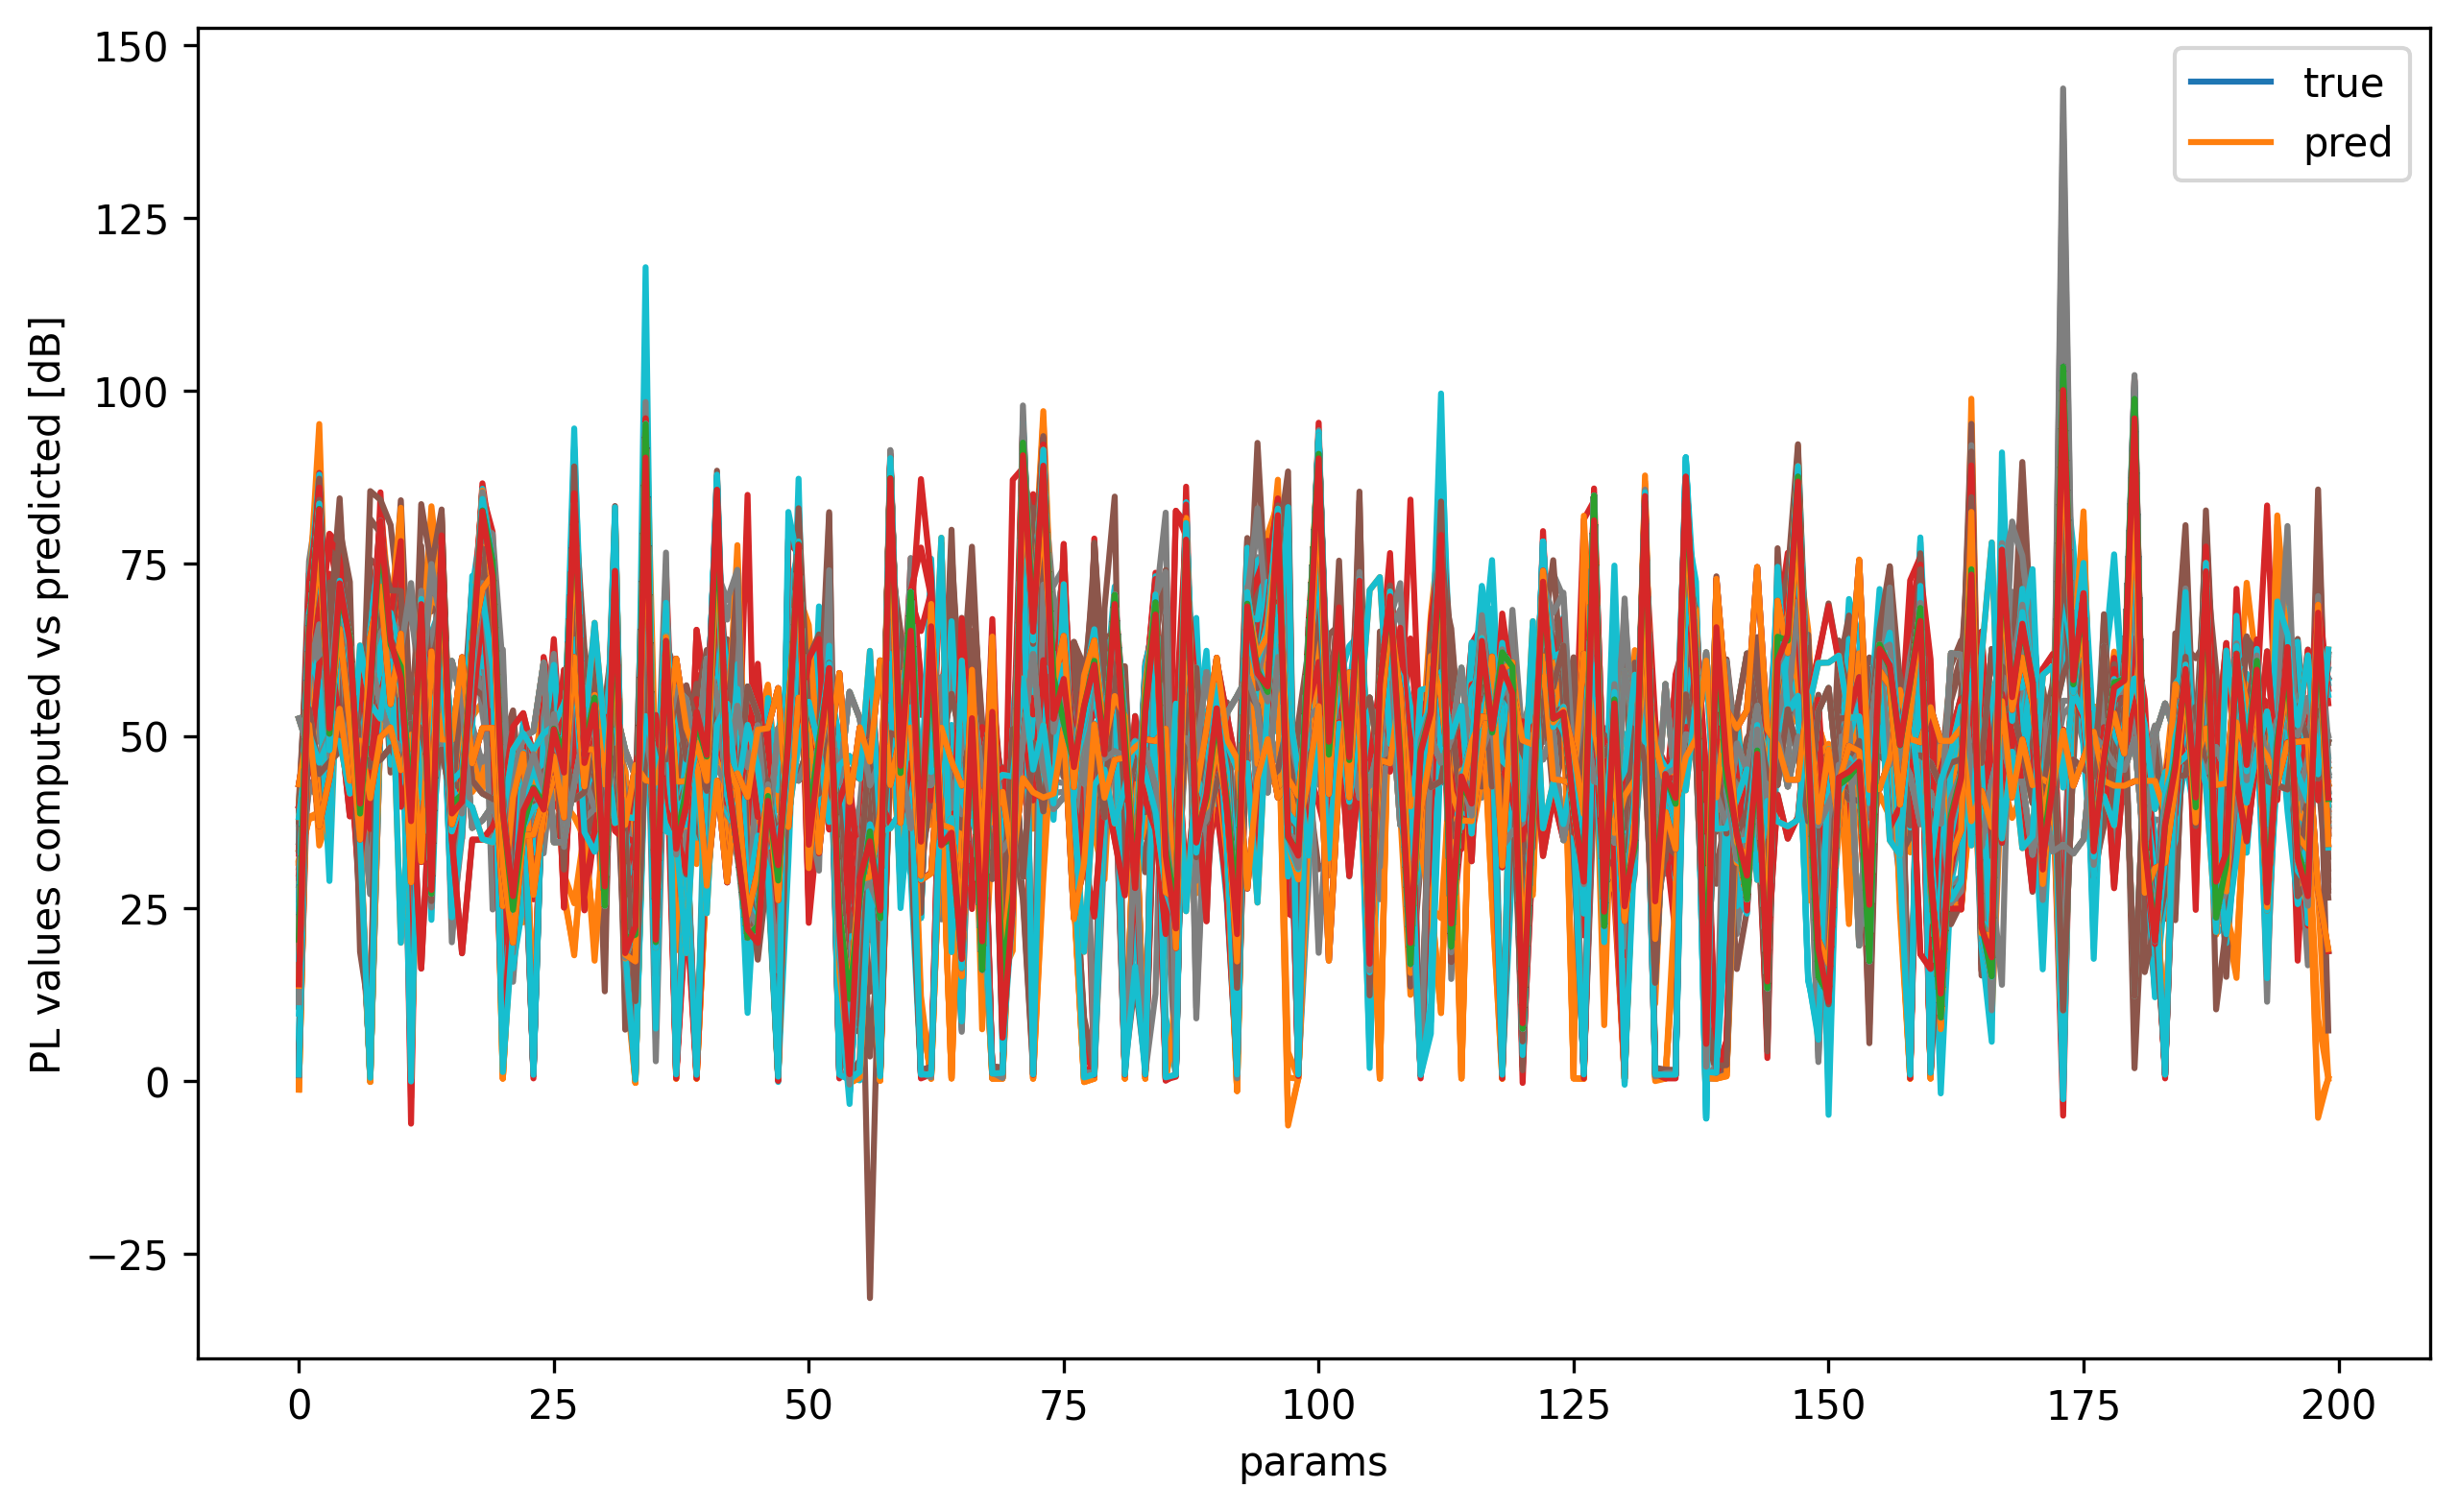

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300


# Store the training and test losses for each grid size for later plotting.
tr_losses = []
te_losses = []
plot_grids = []
plot_steps = []
plot_lambs = []
tr_maes = []
tr_mses = []
tr_mapes = []
tr_r2s = []

train_losses = []
test_losses = []

# Thee parameters for the KAN model.
grids = np.array([5, 8, 10, 15, 20, 30, 40, 50])
steps = np.array([50, 100, 200, 300])
k = 3
lamb = np.array([0.02, 0.002, 0.0002, 0.00002, 0.000002])

for g in range(grids.shape[0]):
    for s in range(steps.shape[0]):
        for l in range(lamb.shape[0]):
            model= KAN(
                width=[6,3,2,1],
                grid=grids[g], 
                k=3, 
                seed=42, 
                device=device, 
            ) 
            
            print(f"Grid size: {grids[g]}, steps {steps[s]}, {lamb[l]}")
            results = model.fit(dataset, opt="LBFGS", lamb=lamb[l], steps=steps[s], lamb_entropy=2.)
            
            if not np.isnan(results['train_loss']).any():
                train_losses += results['train_loss']
                test_losses += results['test_loss']

                tr_mse, tr_rmse, tr_mae, tr_mape, tr_r2 = eval_kan(model, nan, dataset);

                plot_grids.append(grids[g])
                plot_steps.append(steps[s])
                plot_lambs.append(lamb[l])
                print(plot_lambs)
                
                tr_losses.append(np.array(train_losses).mean())
                te_losses.append(np.array(test_losses).mean())
                tr_maes.append(tr_mae)
                tr_mses.append(tr_mse)
                tr_mapes.append(tr_mape)
                tr_r2s.append(tr_r2)


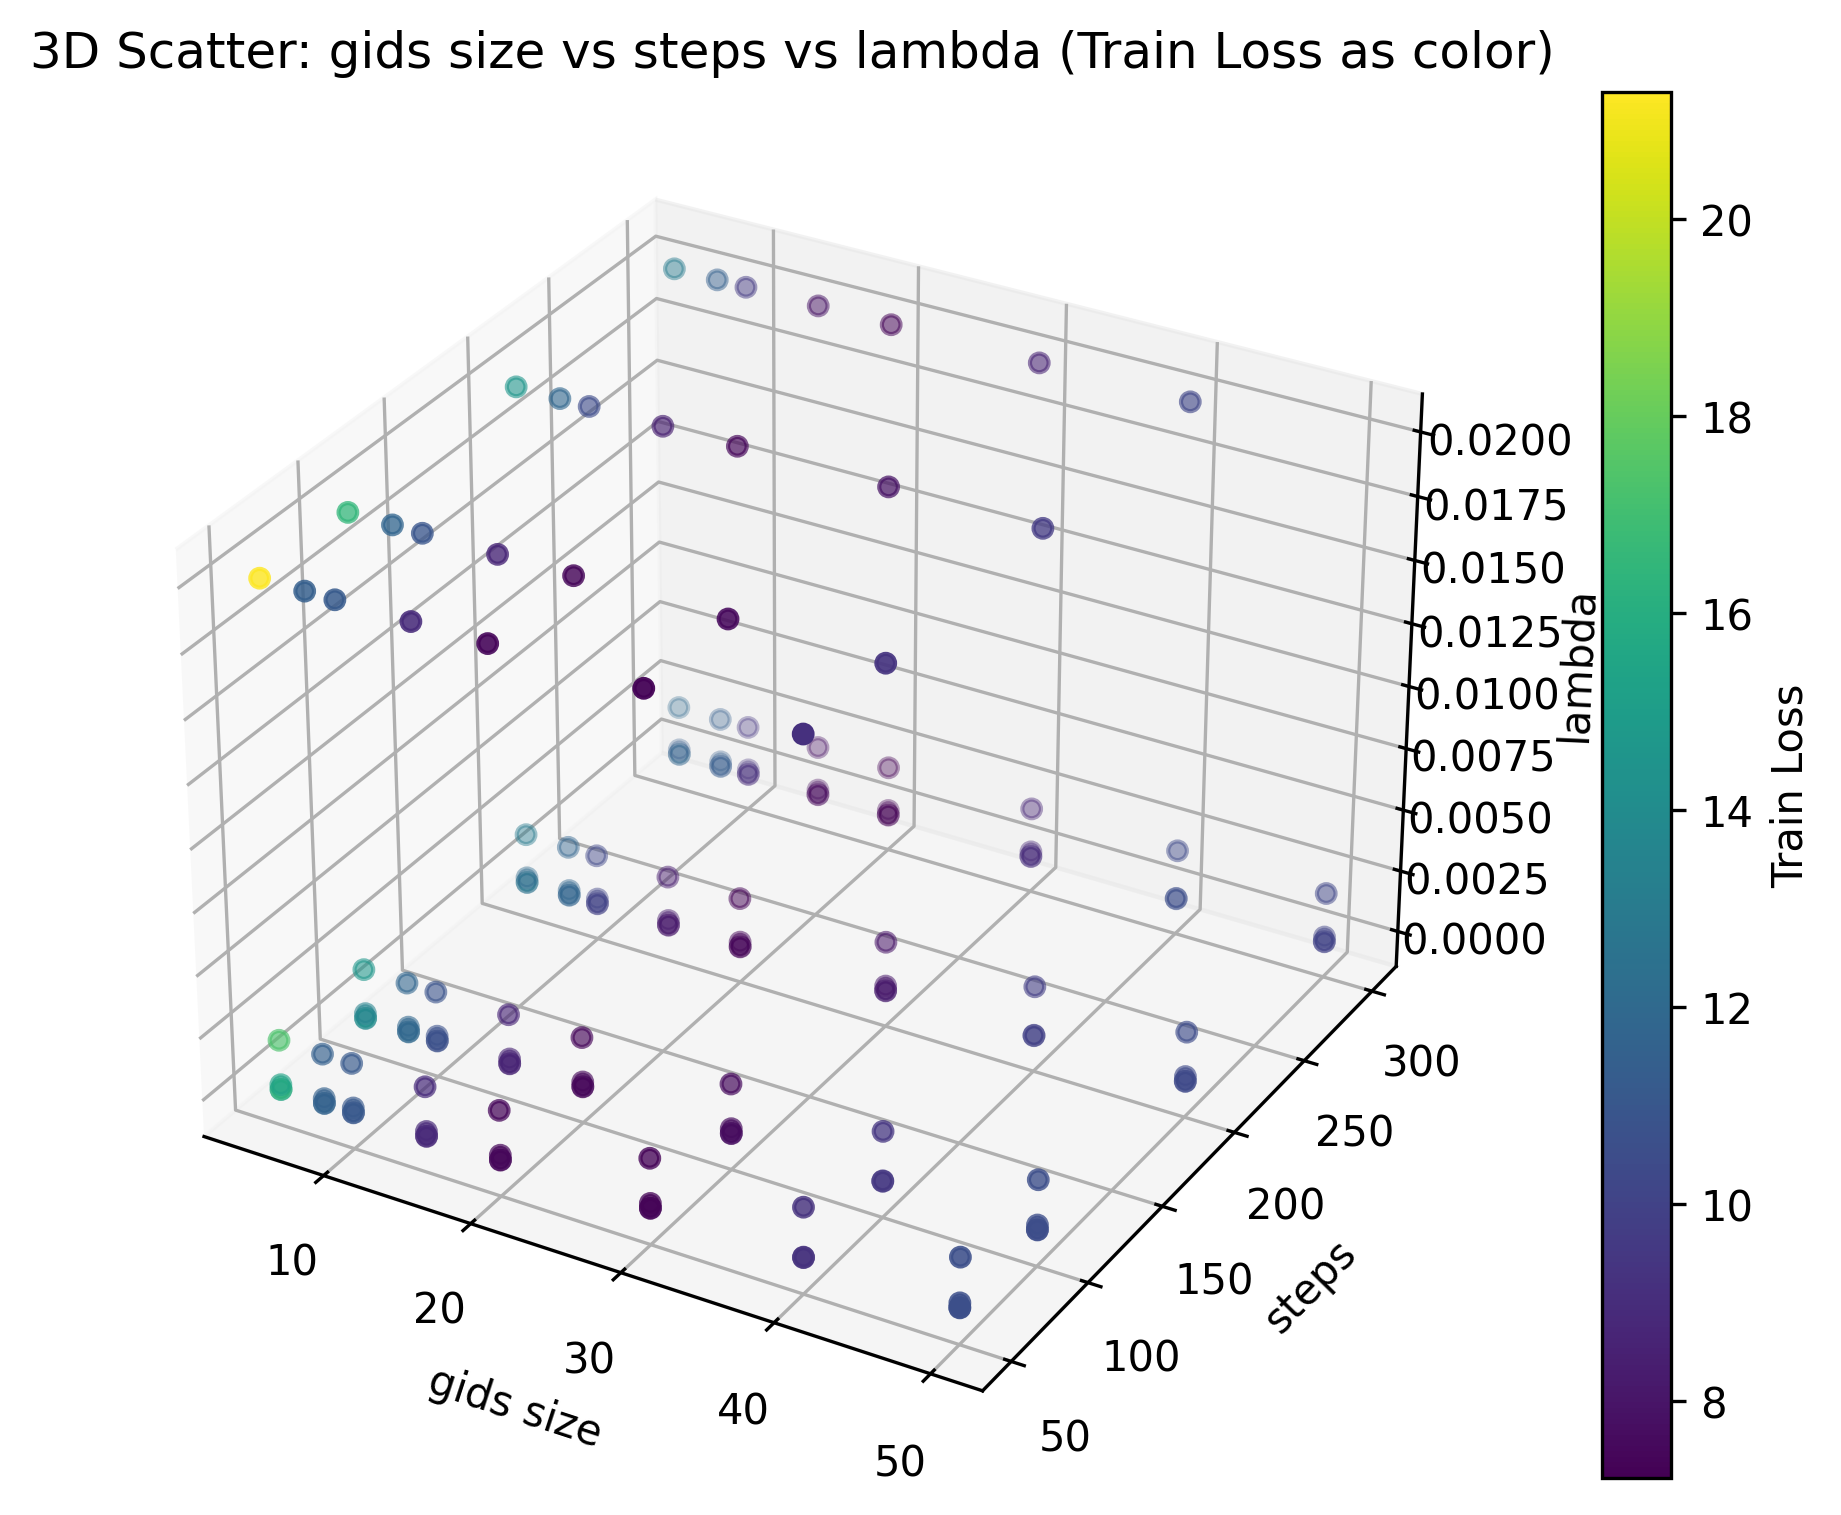

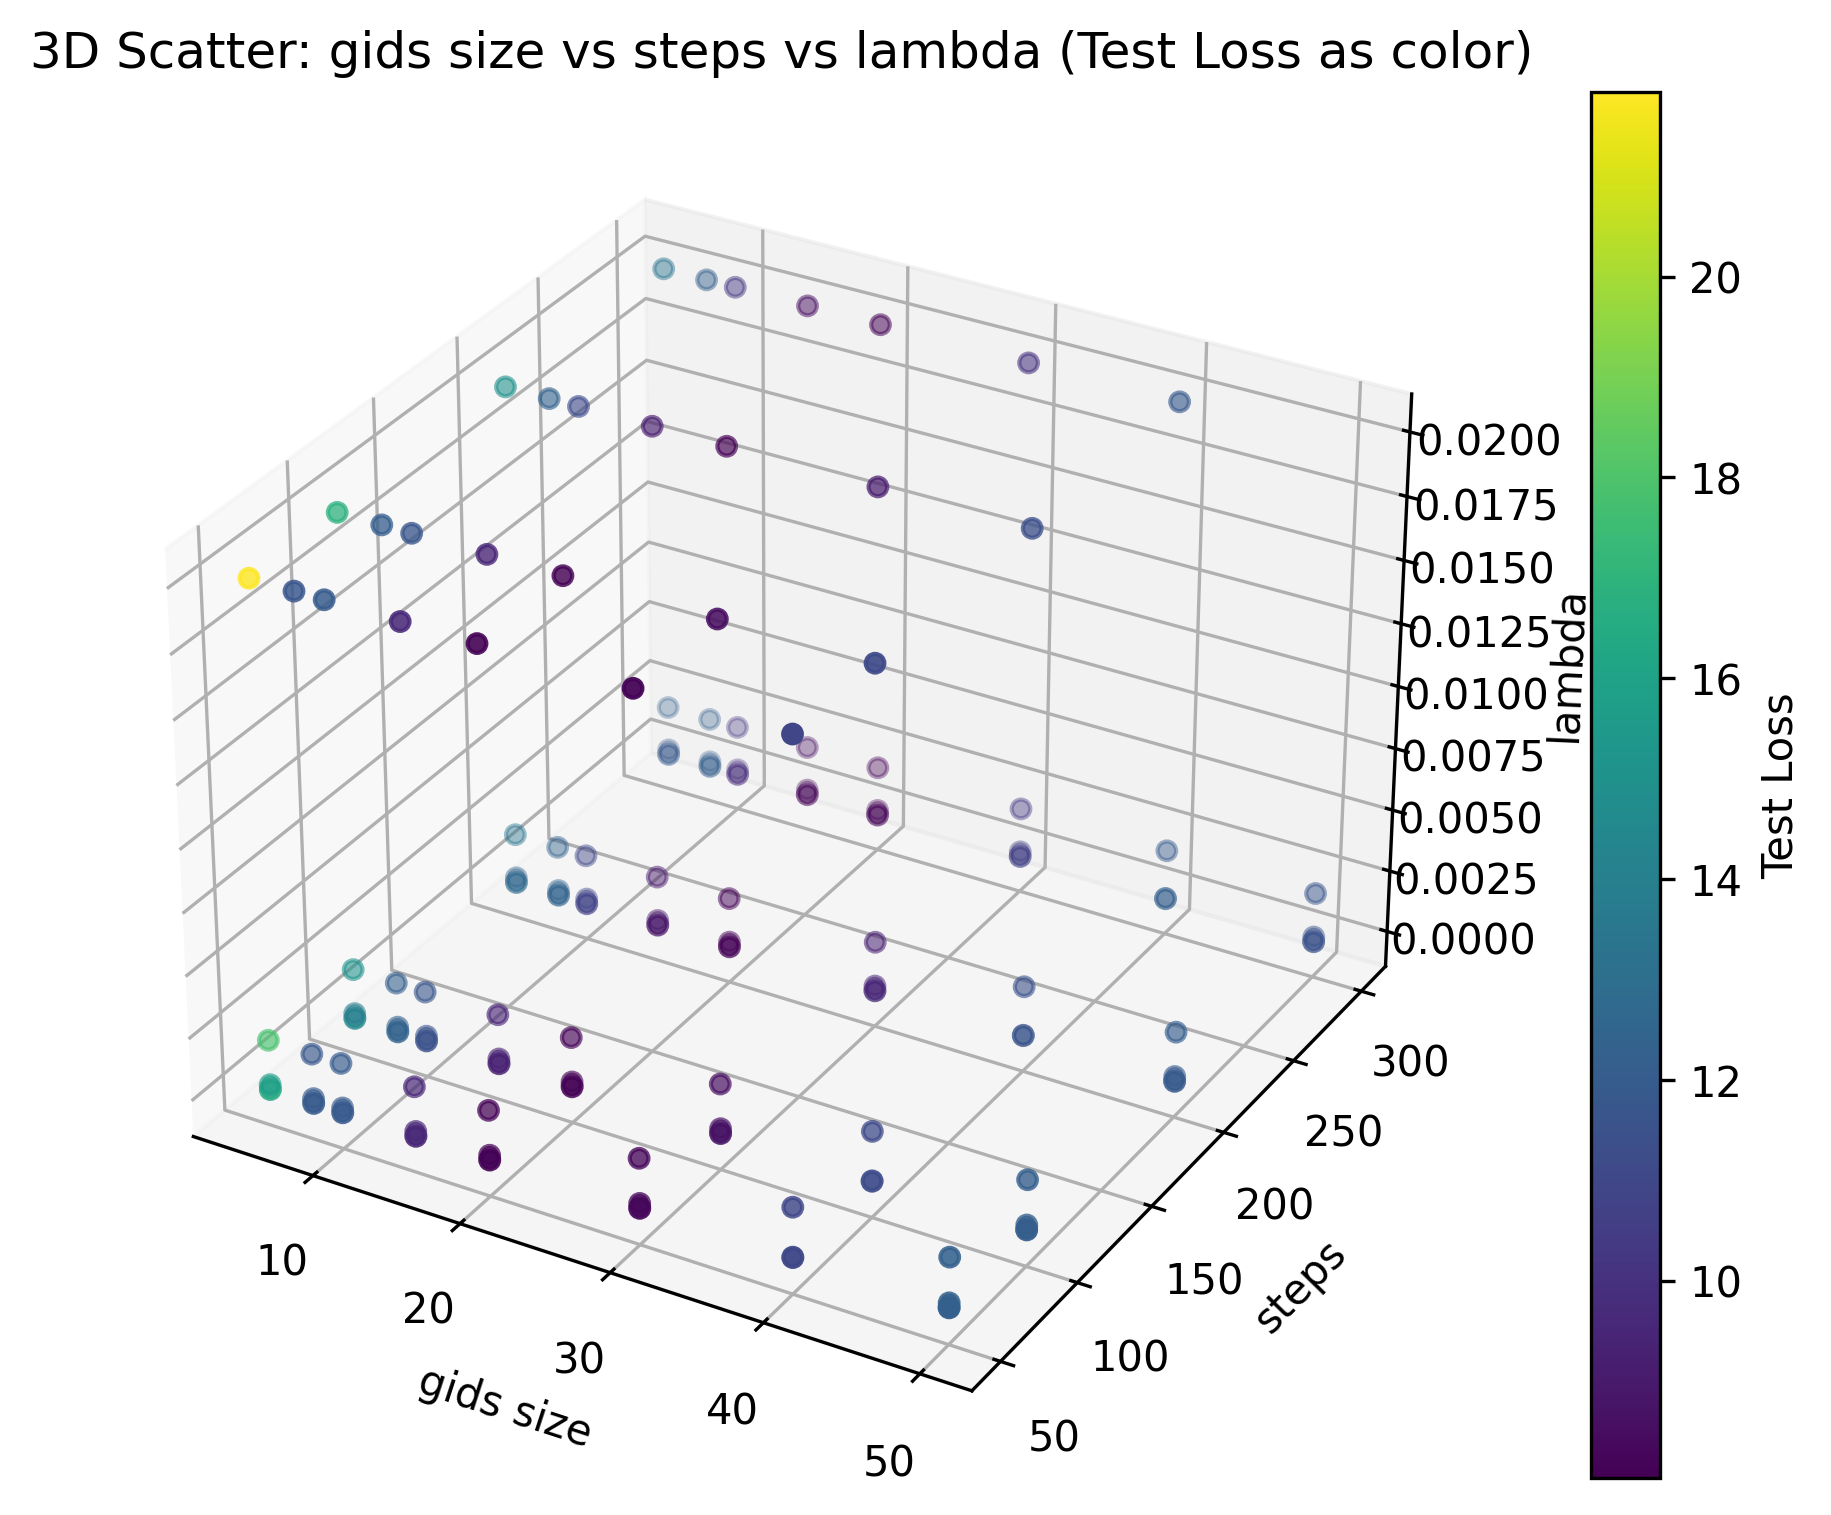

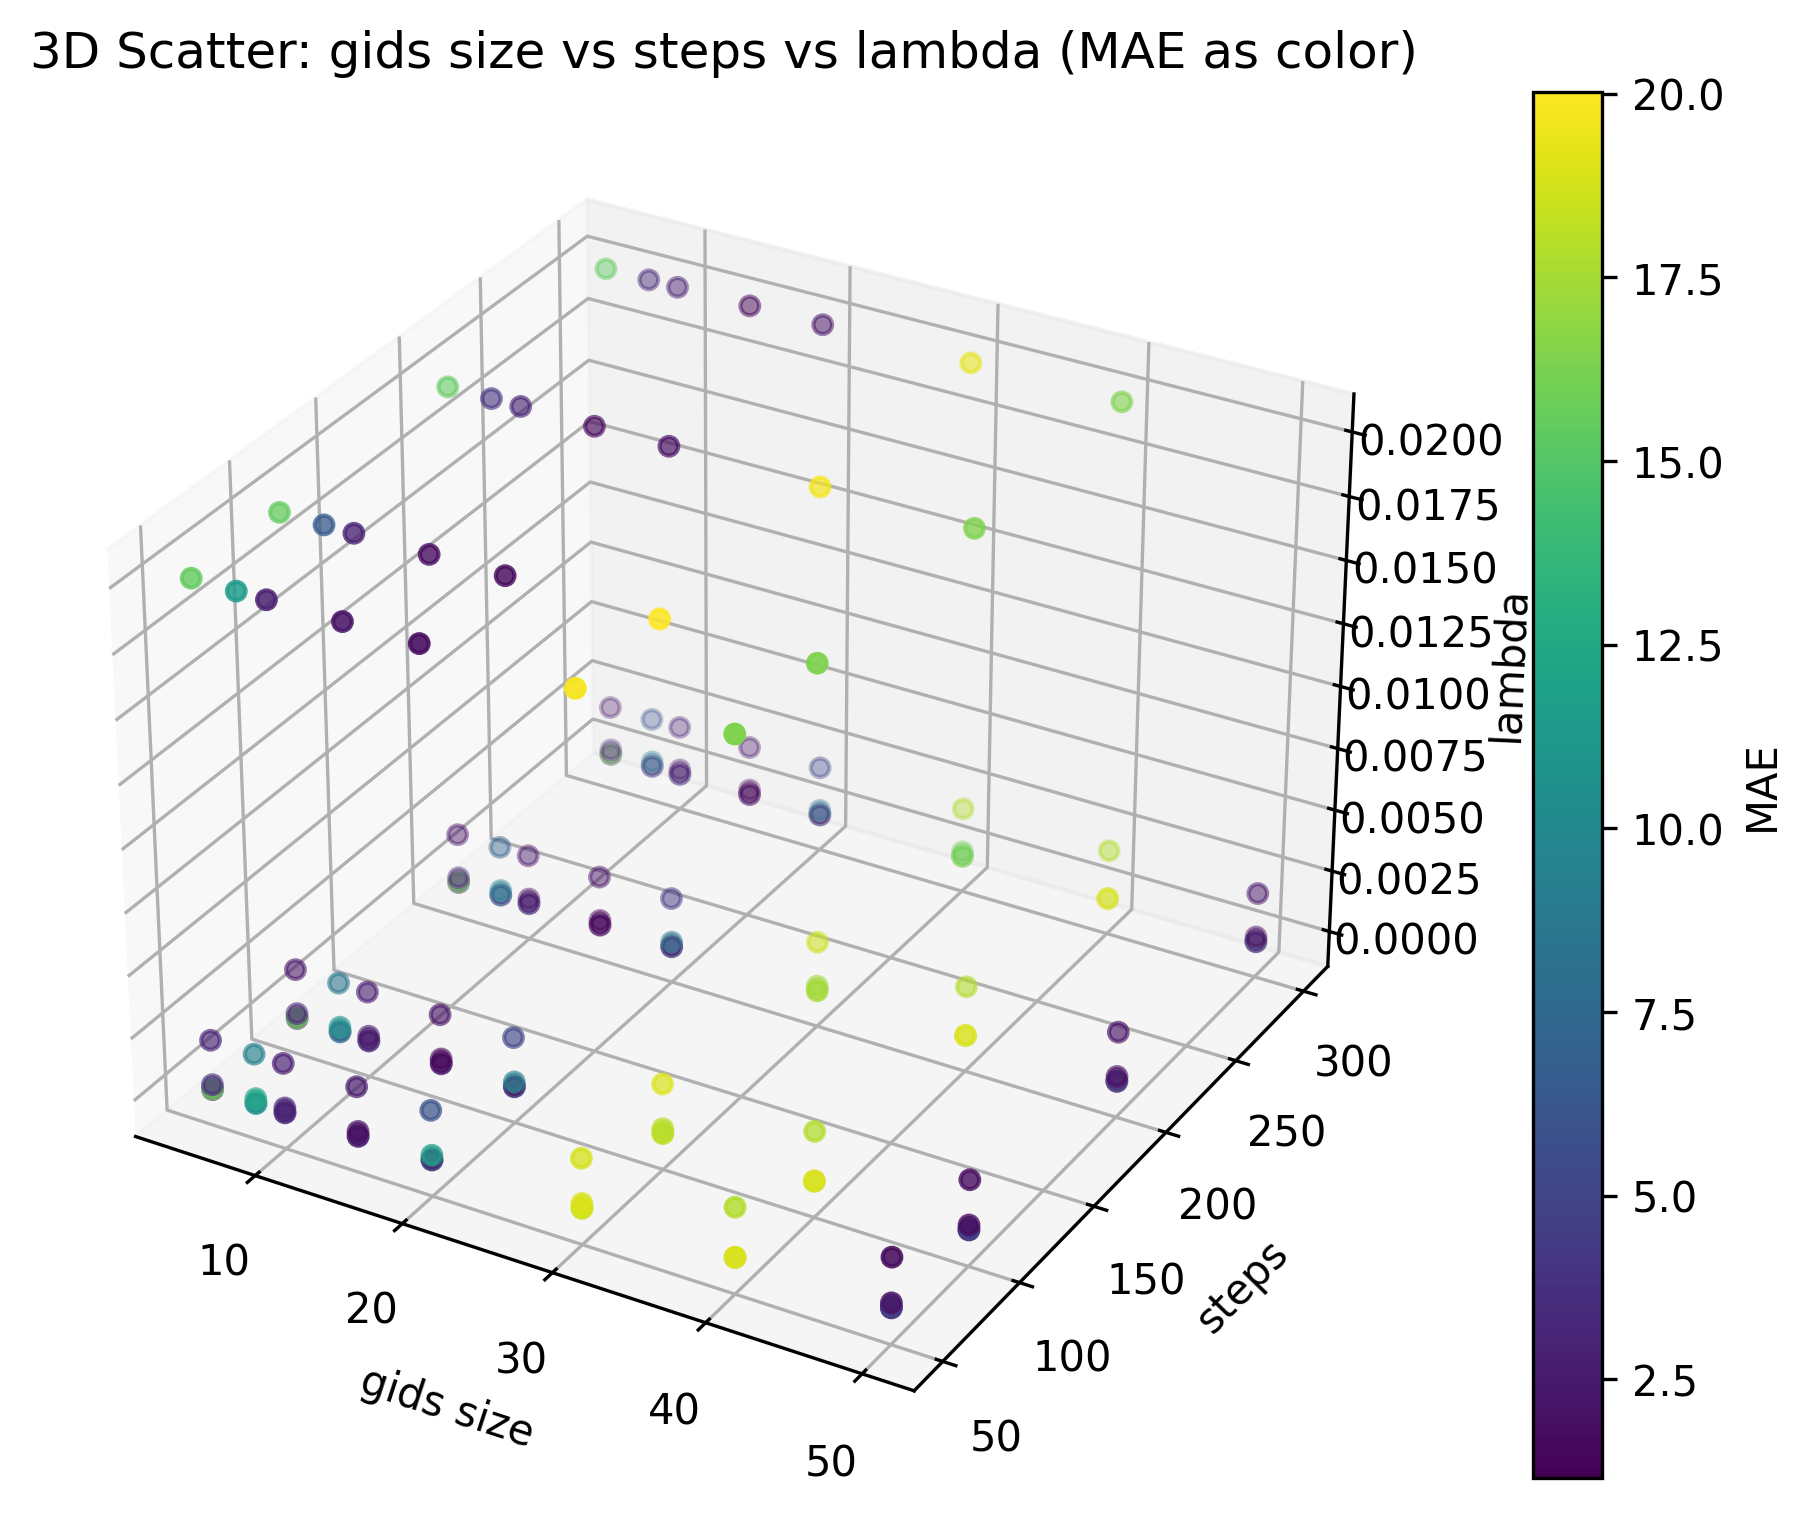

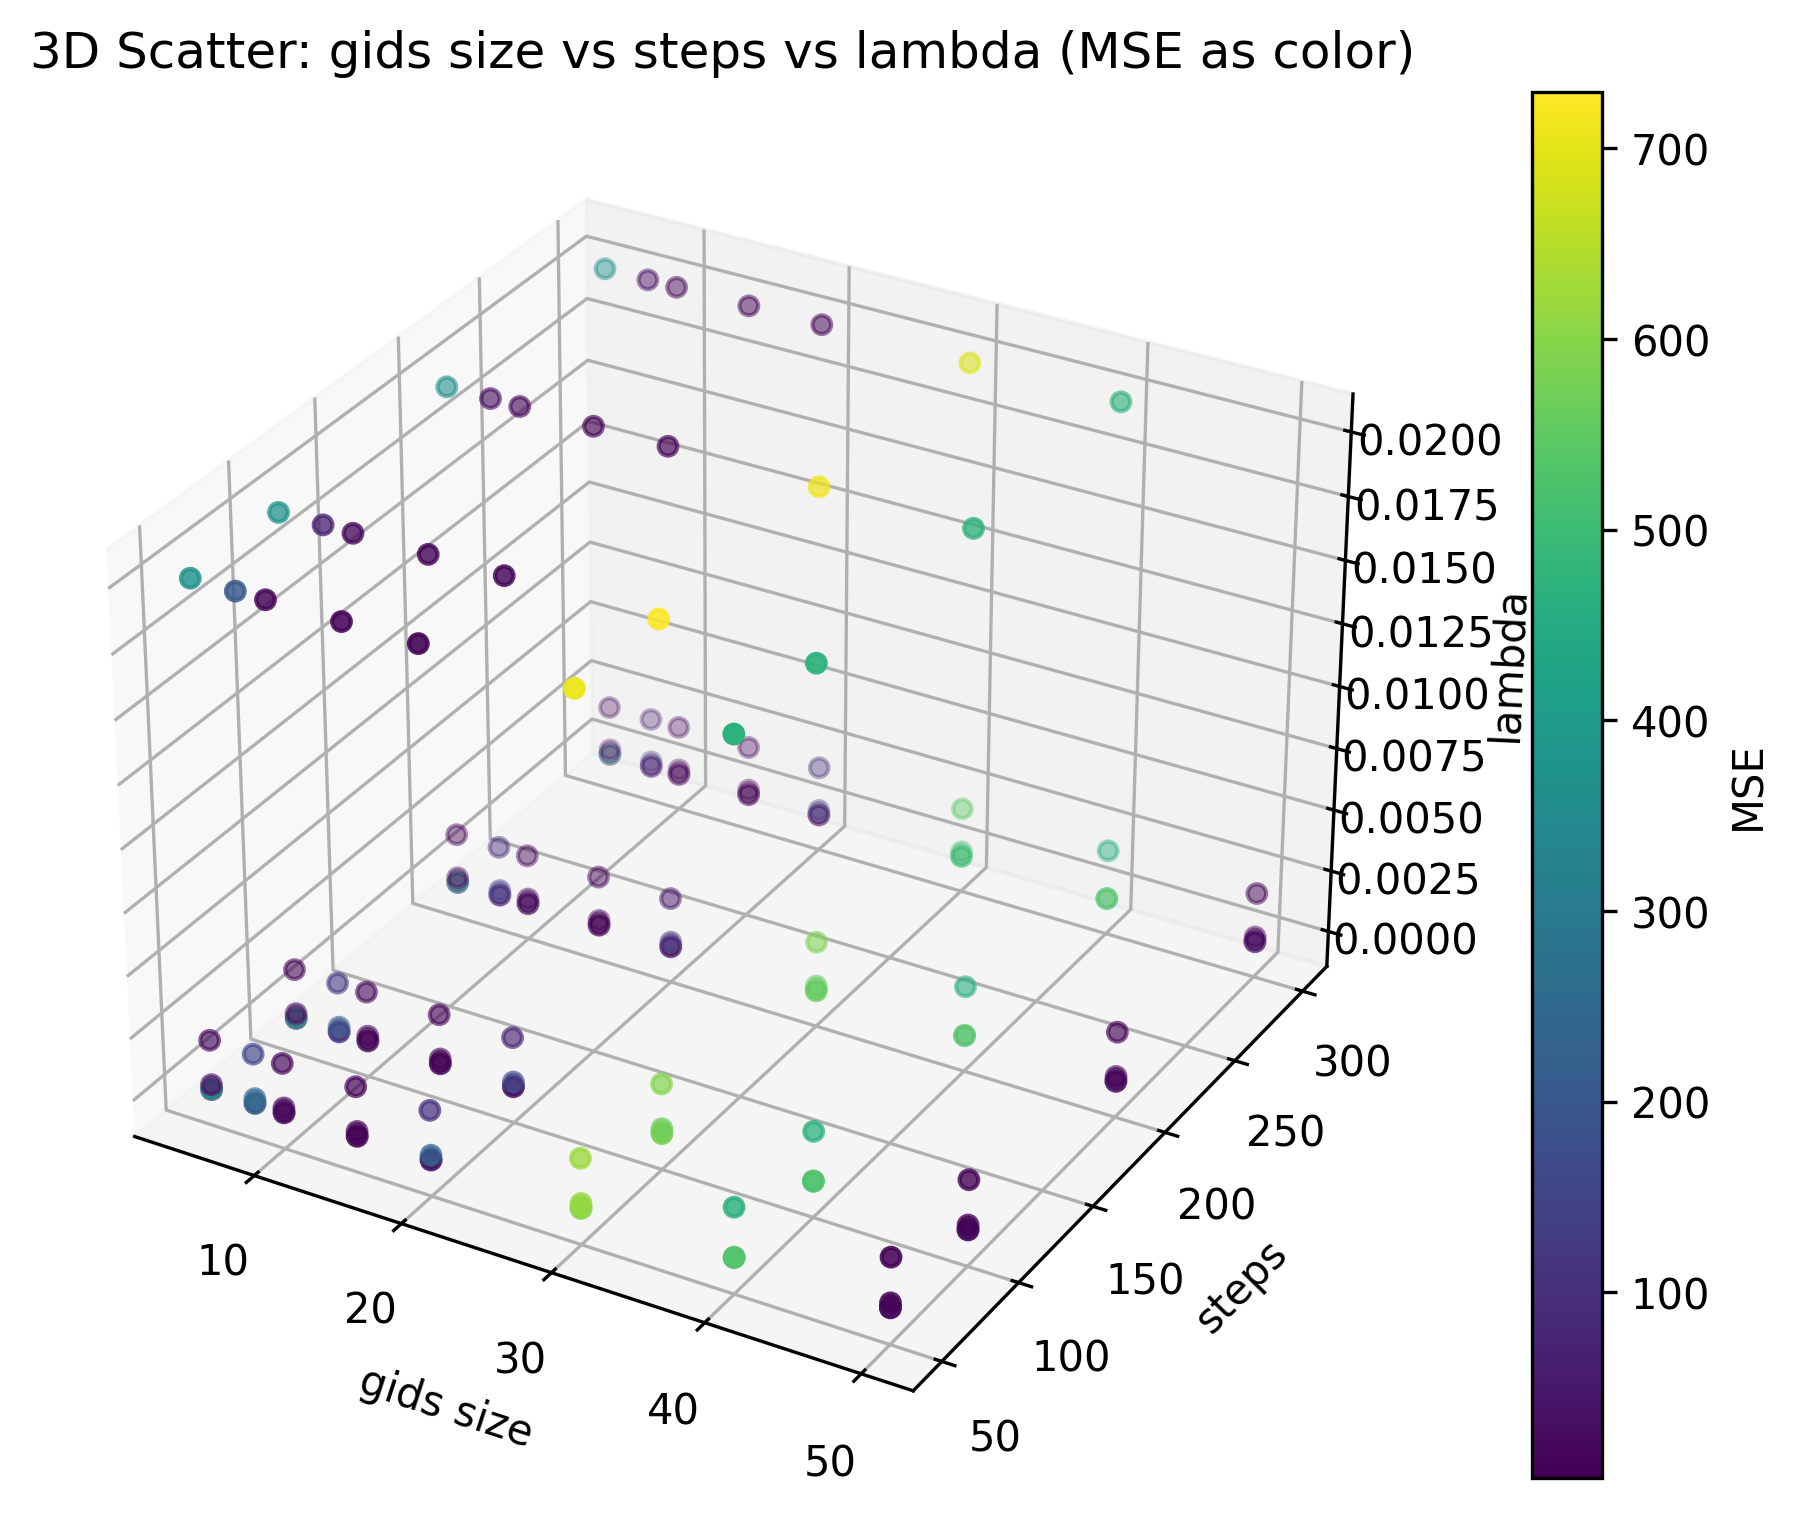

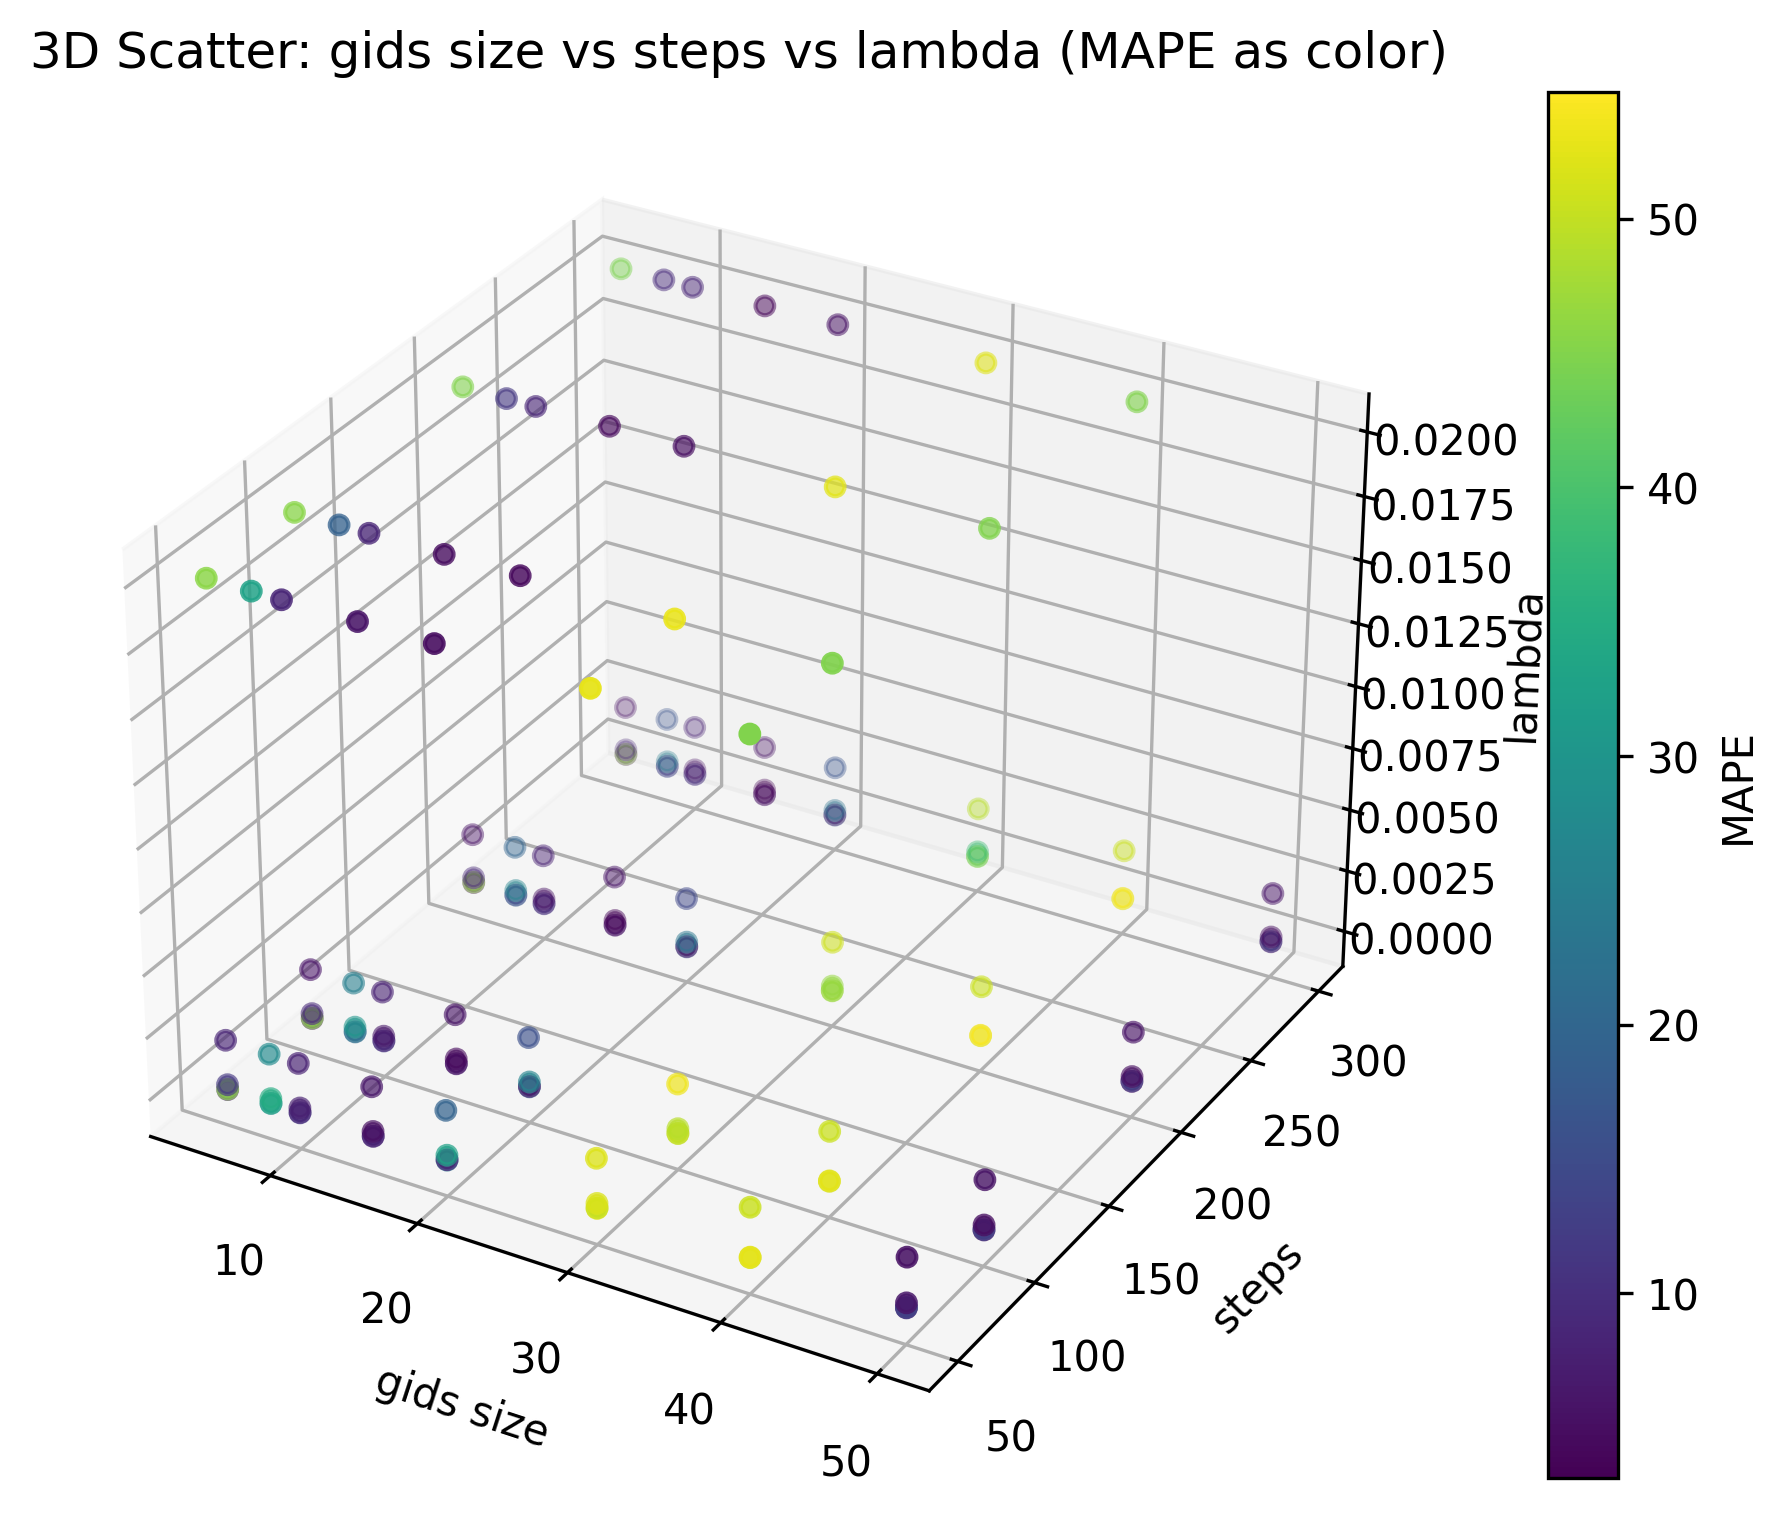

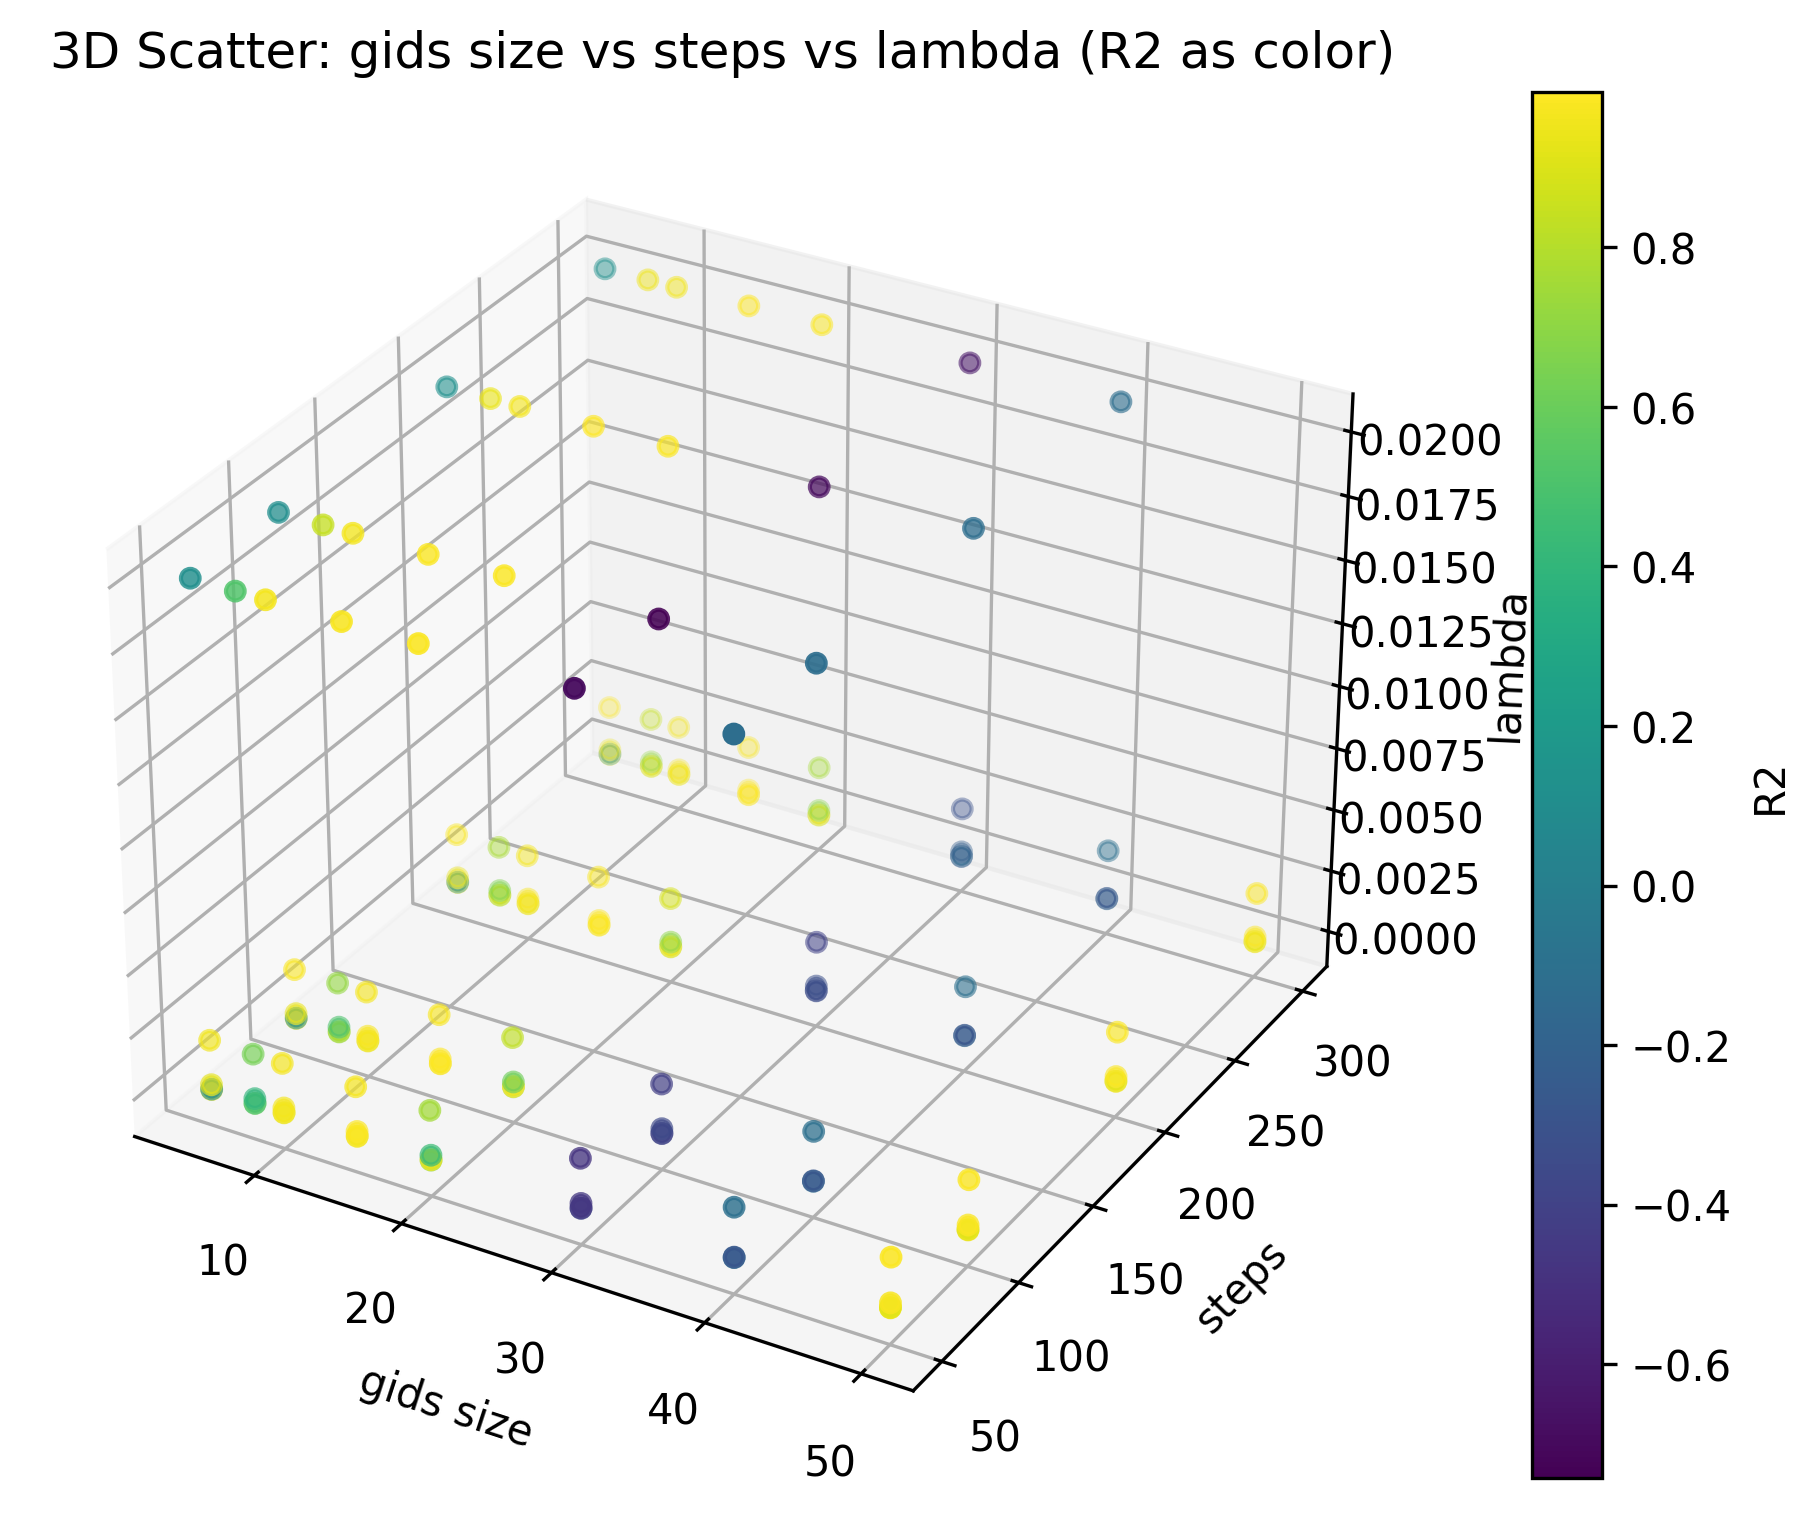

In [17]:
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_losses, "Train Loss")
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, te_losses, 'Test Loss')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_maes, 'MAE')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_mses, 'MSE')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_mapes, 'MAPE')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_r2s, 'R2')

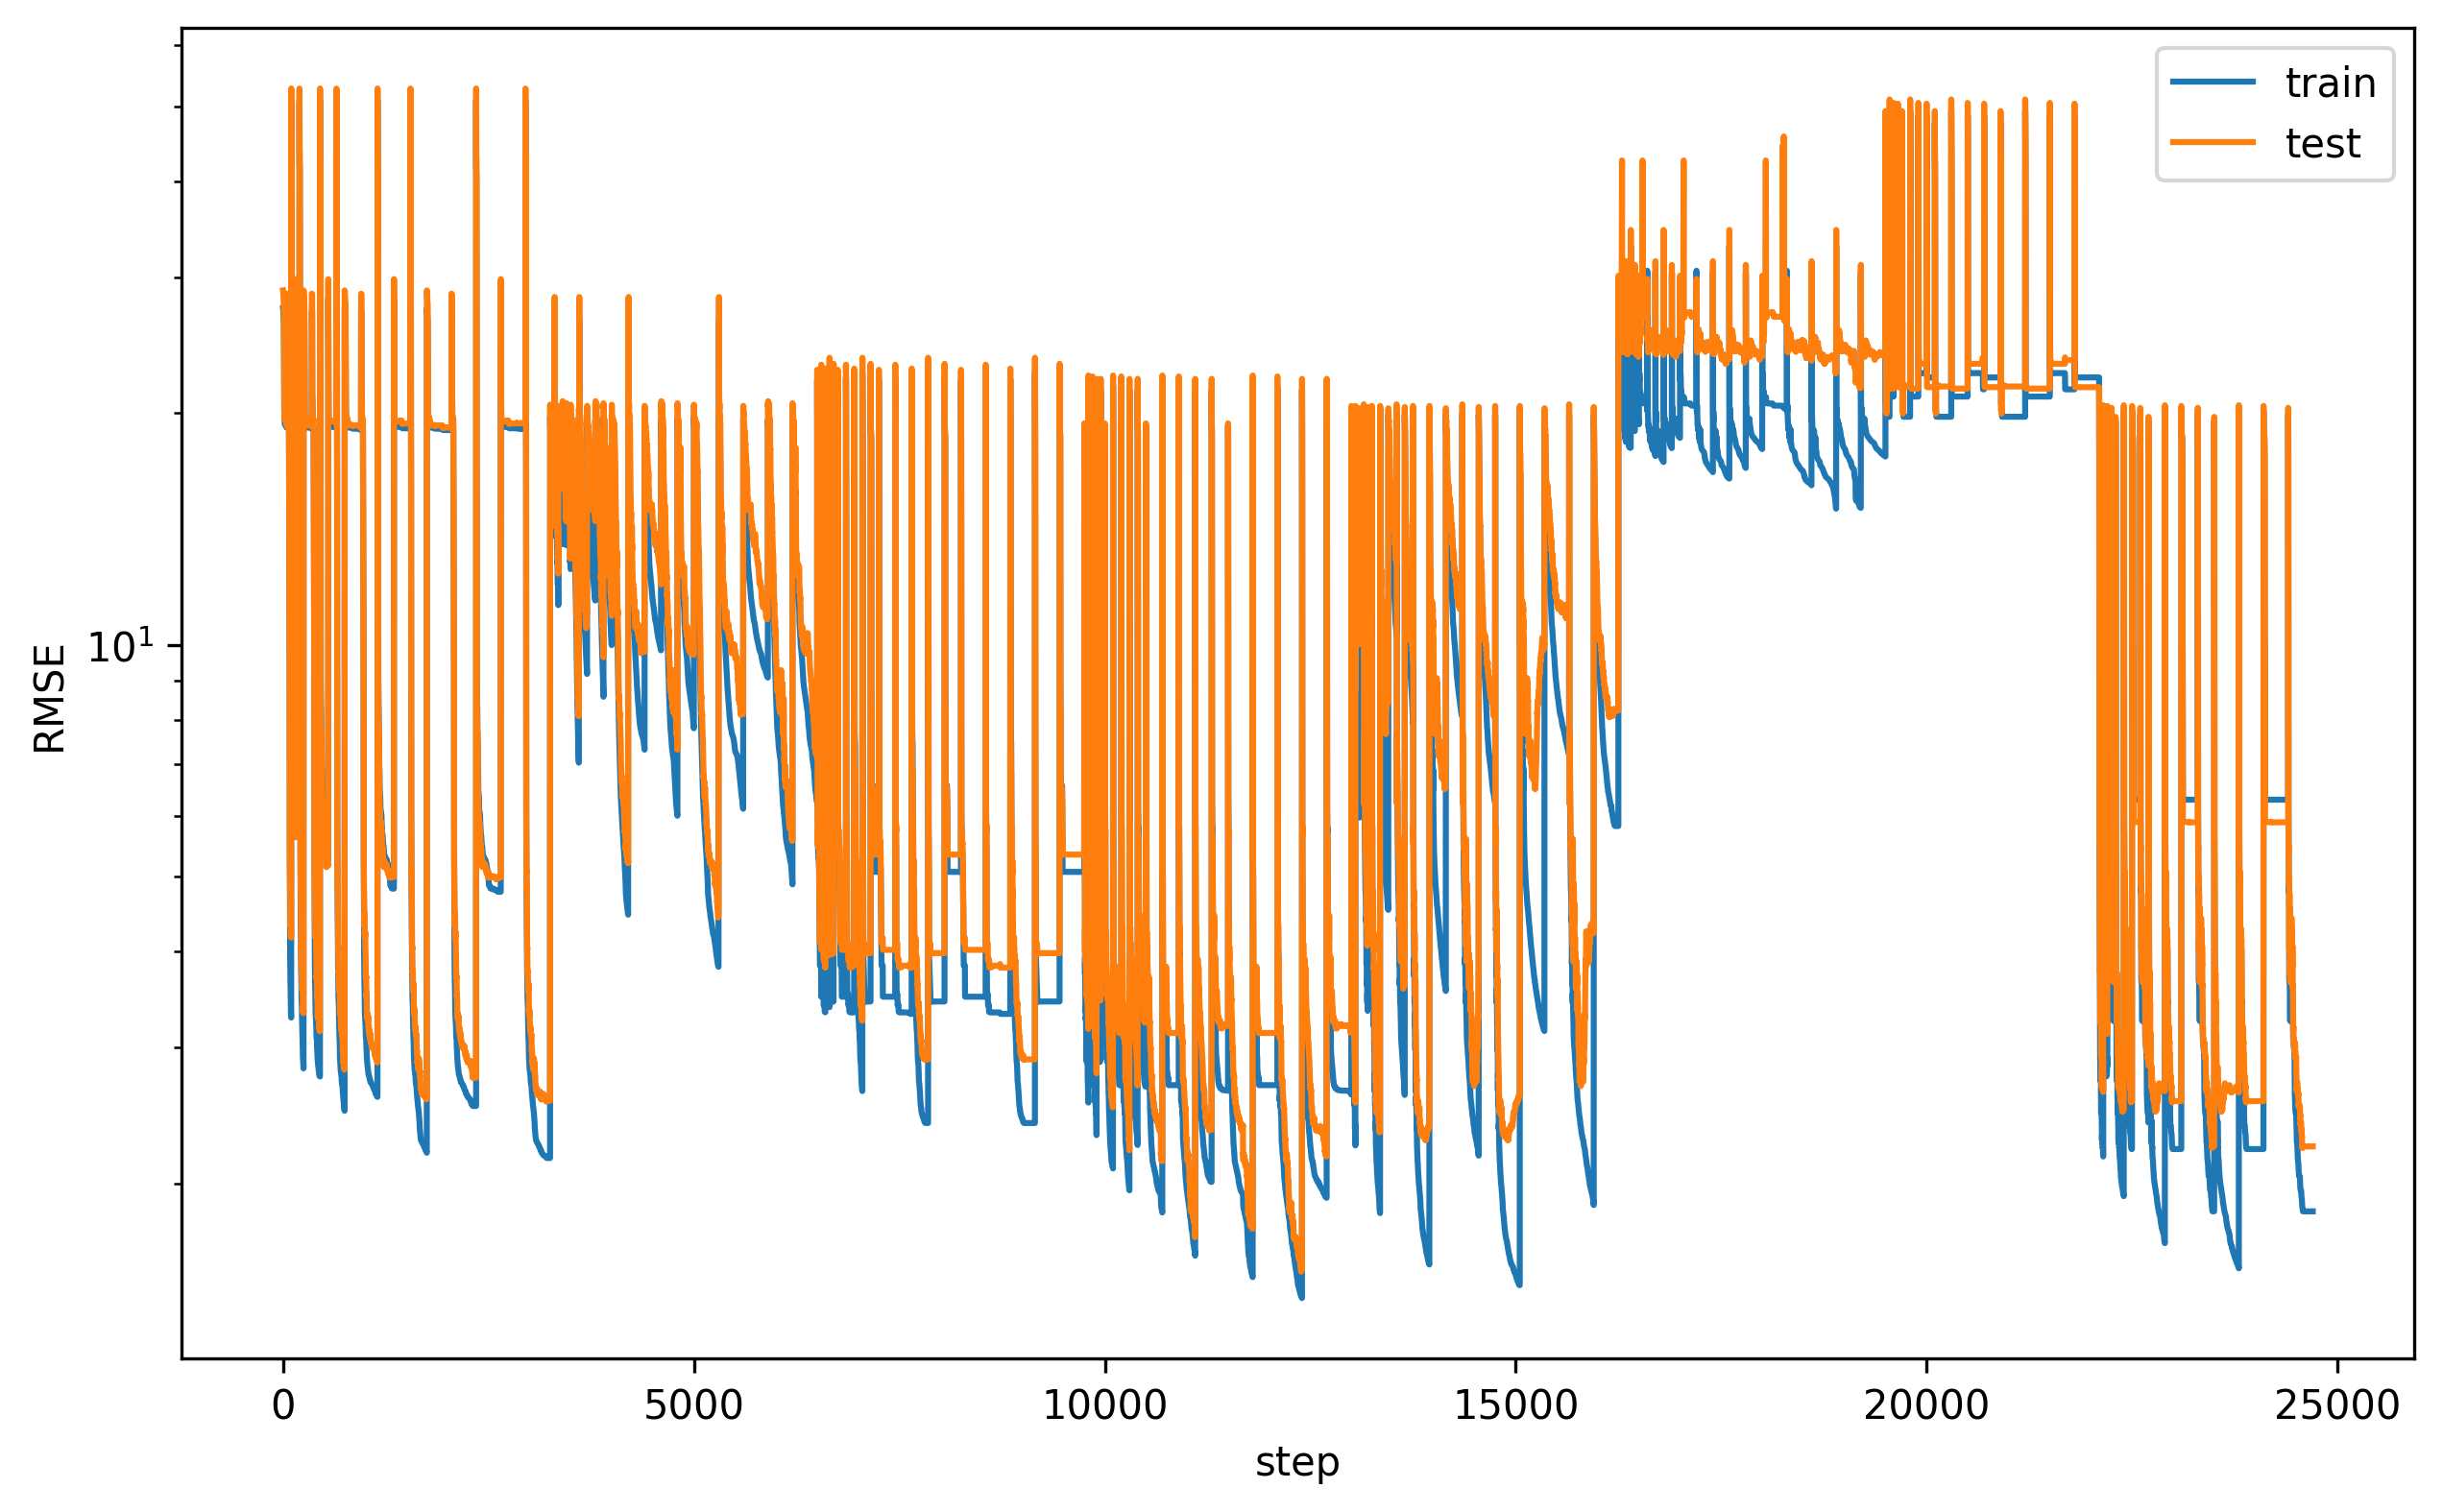

In [18]:
# Plot the training and test losses.
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')